* **libraries for single cell preprocessing**

In [35]:
!pip install scanpy anndata

In [36]:
import pandas as pd
from scipy.io import mmread

import scipy
import anndata as ad
import pickle
import scanpy as sc

* **libraries for lineage coupling analysis**

In [37]:
import codecs
from contextlib import closing
import requests
import csv
import itertools
import statistics
import random
import collections
import copy
import math
import pprint as pp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import argparse
import pandas as pd

# Prepare for analysis

## preprocess count matrix

In [38]:
# load count matrix
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/GSM4185644_stateFate_cytokinePerturbation_normed_counts.mtx.gz'

Matrix = (mmread(data_path))
B = Matrix.todense()
count_matrix = pd.DataFrame(B, range(1, B.shape[0] + 1), range(1, B.shape[1] + 1))
print(count_matrix.shape)

count_matrix.reset_index(inplace=True, drop=True) # reset index with default index

(65075, 25289)


In [39]:
# --------------------
#  Create adata object
# --------------------

# create adata object
exp_X = scipy.sparse.csr_matrix(count_matrix)

# var: gene/features
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/GSM4185644_stateFate_cytokinePerturbation_gene_names.txt.gz'
gene_name = pd.read_csv(data_path, sep="\t", header=None)

exp_var = pd.DataFrame(index=gene_name[0]) # Genes/features
exp_var.index.name = 'geneID'

# obs: cell; also incorporate metadata
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/GSM4185644_stateFate_cytokinePerturbation_metadata.txt.gz'
metadata = pd.read_csv(data_path, sep="\t", header=0)
metadata.set_index('Cell barcode', inplace=True)

exp_obs = pd.DataFrame({'Time point': metadata["Time point"],
                        'Cell type annotation': metadata["Cell type annotation"],
                        'Cytokine condition': metadata["Cytokine condition"],
                        'SPRING-x': metadata["SPRING-x"],
                        'SPRING-y': metadata["SPRING-y"]}, index=metadata.index)

adata = ad.AnnData(exp_X, obs=exp_obs, var=exp_var)
pickle.dump(adata, open("./adata.pickle", "wb"))

adata = pickle.load(open('./adata.pickle', 'rb'))
adata

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 65075 × 25289
    obs: 'Time point', 'Cell type annotation', 'Cytokine condition', 'SPRING-x', 'SPRING-y'

In [40]:
# ----------------------------------------
#  Standard preprocessing of mRNA raw data
# ----------------------------------------

adata.obs_names_make_unique()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [41]:
adata

AnnData object with n_obs × n_vars = 58627 × 1994
    obs: 'Time point', 'Cell type annotation', 'Cytokine condition', 'SPRING-x', 'SPRING-y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [42]:
# save locally
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/preprocessed_scRNA.h5ad'
adata.write(output_dir)

## read in preprocessed data

In [43]:
# --------------------------
#  Read in preprocessed data
# --------------------------
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/preprocessed_scRNA.h5ad'
adata = ad.read(data_path)

adata

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 58627 × 1994
    obs: 'Time point', 'Cell type annotation', 'Cytokine condition', 'SPRING-x', 'SPRING-y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

## extract clonal info.

**Prepare `processed_clone_matrix` for lineage coupling analysis**: include the following information for each cell:  
* **cellID**: cell identity (barcode);
* **cloneID**: inidicates the clone which the cell belongs to (int);
* **ident**: the cluster/state name which the cell belongs to (str).

In [44]:
# -------------------------------
#  Read in metadata; clone matrix
# -------------------------------
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/GSM4185644_stateFate_cytokinePerturbation_metadata.txt.gz'
metadata = pd.read_csv(data_path, sep="\t", header=0)

data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/GSM4185644_stateFate_cytokinePerturbation_clone_matrix.mtx.gz'
Matrix = (mmread(data_path))
B = Matrix.todense()
clone_matrix = pd.DataFrame(B, range(1, B.shape[0] + 1), range(1, B.shape[1] + 1))

clone_matrix = clone_matrix.T  # cell by clone (one-hot coding)
clone_matrix.reset_index(inplace=True, drop=True) # reset index with default index

In [45]:
print(metadata.shape)
print(sorted(metadata['Time point'].unique()))
print(sorted(metadata['Cell type annotation'].unique()))
print(sorted(metadata['Cytokine condition'].unique()))
metadata.head(5)

(65075, 7)
[2, 4, 6]
['Ba', 'Eos', 'Er', 'Ma', 'Mk', 'Mo', 'Neu', 'Undifferentiated', 'cDC', 'pDC1', 'pDC2']
['Epo', 'G-csf', 'M-csf', 'SCF', 'full cocktail']


,Library,Cell barcode,Time point,Cell type annotation,Cytokine condition,SPRING-x,SPRING-y
0,d6_all_3,CCGACTTT-AGAACGGG,6,Mo,full cocktail,1548.110390,-216.382304
1,d6_all_3,GTACGGAC-ATGACTTT,6,Mo,full cocktail,3322.717065,49.209629
2,d6_all_3,CTGTCGCA-GTTACCGC,6,Ba,full cocktail,-500.015028,-2181.520527
3,d6_all_3,GATGTGGC-CCGTGTTT,6,Undifferentiated,full cocktail,740.904438,-129.771060
4,d6_all_3,CTCTGCGT-GGATAAAG,6,Undifferentiated,full cocktail,234.196292,1179.950718


In [46]:
clone_matrix.head(5)

,1,2,3,4,5,6,7,8,9,10,...,5248,5249,5250,5251,5252,5253,5254,5255,5256,5257
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print(clone_matrix.shape)

(65075, 5257)


In [48]:
# -------------------------------
#  Preprocessing the clone_matrix
# -------------------------------

# remove clones that have < 5 cells in it
#rows are cells columns are clone id
processed_clone_matrix = clone_matrix.loc[:, clone_matrix.sum(axis=0) >= 5]

# remove cells that don't belong to any clones
processed_clone_matrix = processed_clone_matrix.loc[processed_clone_matrix.sum(axis=1) != 0,:]

# convert 1-hot to cloneID
processed_clone_matrix = processed_clone_matrix.idxmax(1)
processed_clone_matrix = pd.DataFrame({'cloneID':processed_clone_matrix.values}, index=processed_clone_matrix.index)

# --------------------
#  Concat w/ clusterID
# --------------------
i = processed_clone_matrix.index
processed_clone_matrix = pd.concat([processed_clone_matrix, metadata.loc[i, ['Cell barcode', 'Cell type annotation']]], axis=1, ignore_index=False)
processed_clone_matrix.reset_index(drop=True, inplace=True)

processed_clone_matrix.rename(columns = {'Cell barcode':'cellID',
                                         'Cell type annotation':'ident'},
                              inplace = True)

# save processed data locally
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/processed_clone_table.csv.gz'
processed_clone_matrix.to_csv(output_dir, compression='gzip')

In [49]:
print(processed_clone_matrix.shape)
processed_clone_matrix.head()

(16772, 3)


,cloneID,cellID,ident
0,2243,CTGTCGCA-GTTACCGC,Ba
1,1417,CTCTGCGT-GGATAAAG,Undifferentiated
2,2844,GTCAGACC-GAATACGC,Ma
3,2786,CATTCATT-TACCAGGC,Undifferentiated
4,4763,GTATACGT-ACGTATAC,Mo


## read in clonal table

In [50]:
path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/processed_clone_table.csv.gz'
clone_table = pd.read_csv(path,index_col=0, header=0)

In [51]:
clone_table.head(2)

,cloneID,cellID,ident
0,2243,CTGTCGCA-GTTACCGC,Ba
1,1417,CTCTGCGT-GGATAAAG,Undifferentiated


# 0-Basic analysis

## cell state visualization

In [52]:
# --------------------------
#  Read in preprocessed data
# --------------------------
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/preprocessed_scRNA.h5ad'
adata = ad.read(data_path)

adata

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 58627 × 1994
    obs: 'Time point', 'Cell type annotation', 'Cytokine condition', 'SPRING-x', 'SPRING-y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [53]:
# add SPRING coordinates to adata
adata.obsm["SPRING coordinates"] = pd.concat([adata.obs['SPRING-x'], adata.obs['SPRING-y']], axis=1, ignore_index=False)

In [54]:
adata.obs['Time point'] = adata.obs['Time point'].astype('category')

In [55]:
print(adata.obsm["SPRING coordinates"].head())

                      SPRING-x     SPRING-y
Cell barcode                               
CCGACTTT-AGAACGGG  1548.110390  -216.382304
GTACGGAC-ATGACTTT  3322.717065    49.209629
CTGTCGCA-GTTACCGC  -500.015028 -2181.520527
GATGTGGC-CCGTGTTT   740.904438  -129.771060
CTCTGCGT-GGATAAAG   234.196292  1179.950718


In [56]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: SPRING coordinates)


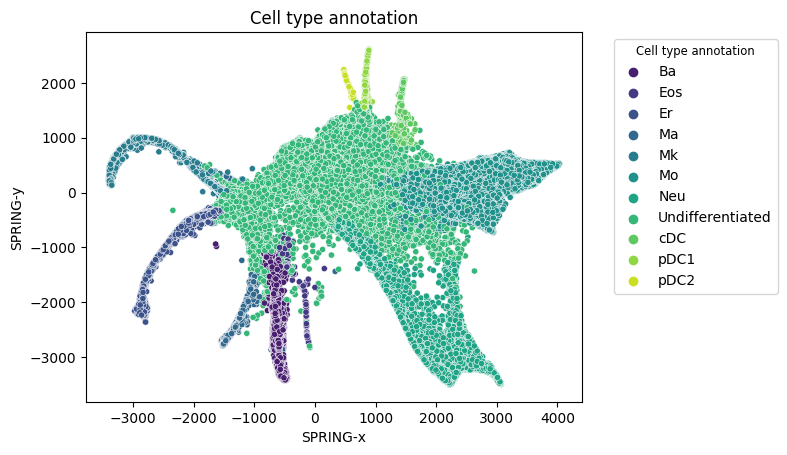

In [57]:
import matplotlib.pyplot as plt
adata.obs['Cell type annotation'] = adata.obs['Cell type annotation'].astype('category')

# Create a scatter plot colored by 'Cell type annotation'
sns.scatterplot(
    x=adata.obsm["SPRING coordinates"]['SPRING-x'],
    y=adata.obsm["SPRING coordinates"]['SPRING-y'],
    hue=adata.obs['Cell type annotation'],
    palette='viridis',  # Or any other palette
    s=20  # Size of the dots
)

plt.title("Cell type annotation")
plt.legend(title='Cell type annotation', fontsize='medium', title_fontsize='small',bbox_to_anchor=(1.05, 1),  # Places the legend to the right of the plot
    loc='upper left')
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/spring_cell_type.png'
plt.savefig(output_dir, dpi=300, bbox_inches="tight", format="png")
plt.show()



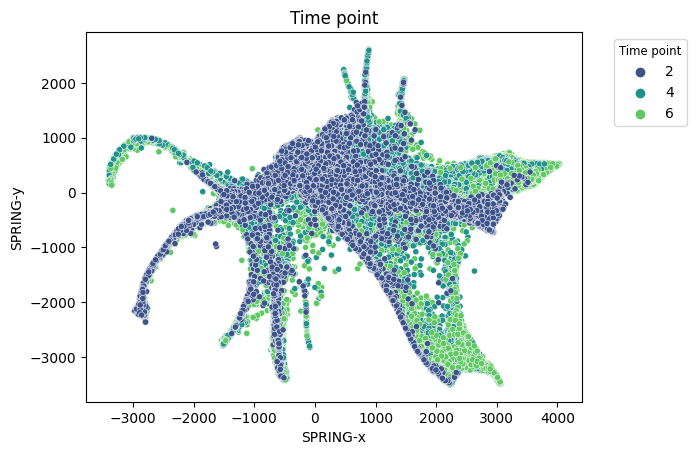

In [58]:
import matplotlib.pyplot as plt
adata.obs['Time point'] = adata.obs['Time point'].astype('category')

# Create a scatter plot colored by 'Cell type annotation'
sns.scatterplot(
    x=adata.obsm["SPRING coordinates"]['SPRING-x'],
    y=adata.obsm["SPRING coordinates"]['SPRING-y'],
    hue=adata.obs['Time point'],
    palette='viridis',  # Or any other palette
    s=20  # Size of the dots
)

plt.title("Time point")
plt.legend(title='Time point', fontsize='medium', title_fontsize='small',bbox_to_anchor=(1.05, 1),  # Places the legend to the right of the plot
    loc='upper left')
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/spring_time.png'
plt.savefig(output_dir, dpi=300, bbox_inches="tight", format="png")
plt.show()

## identify progenitor cells

In [59]:
# read in clone table
path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/processed_clone_table.csv.gz'
clone_table = pd.read_csv(path, index_col=0, header=0)

clone_table.head(2)

,cloneID,cellID,ident
0,2243,CTGTCGCA-GTTACCGC,Ba
1,1417,CTCTGCGT-GGATAAAG,Undifferentiated


In [60]:
adata.obs.head(2)

,Time point,Cell type annotation,Cytokine condition,SPRING-x,SPRING-y,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
Cell barcode,,,,,,,,,,
CCGACTTT-AGAACGGG,6,Mo,full cocktail,1548.110390,-216.382304,1063,1062,3228.364334,0.0,0.0
GTACGGAC-ATGACTTT,6,Mo,full cocktail,3322.717065,49.209629,1208,1207,3228.774592,0.0,0.0


In [61]:
print(clone_table.shape)  # has removed cells that don't belong to any clone
print(adata.obs.shape)

(16772, 3)
(58627, 10)


In [62]:
clone_table.set_index('cellID', inplace=True)
clone_table.index.name = 'Cell barcode'

In [63]:
# -------------------------------------
#  Drop duplicated index in clone table
# -------------------------------------

# clone table: additional processing
print((clone_table.index.duplicated()).sum())  # number of duplicated index
clone_table.loc['CCACCTCT-ACGAAACG']  # checked - duplicated rows

1581


,cloneID,ident
Cell barcode,,
CCACCTCT-ACGAAACG,5196,Neu
CCACCTCT-ACGAAACG,5196,Neu


In [64]:
clone_table = clone_table[~clone_table.index.duplicated(keep='first')]
clone_table.loc['CCACCTCT-ACGAAACG']

cloneID    5196
ident       Neu
Name: CCACCTCT-ACGAAACG, dtype: object

In [65]:
# --------------------------
#  Add clonal info. to adata
# --------------------------
# remove the index that is in clone_table, but not in adata
idx_not_in_adata = [i for i in clone_table.index if i not in adata.obs.index]
i = pd.Index(idx_not_in_adata)
idx_to_assign_clone = clone_table.index.drop(i)

idx_assign_neg = [i for i in adata.obs.index if i not in idx_to_assign_clone]
idx_assign_neg = pd.Index(idx_assign_neg)

c1 = clone_table.loc[idx_to_assign_clone, 'cloneID'].to_frame()
c2 = pd.DataFrame({'cloneID': -1}, index=idx_assign_neg).astype('int64')
c2.index.name = 'Cell barcode'

pd.concat([c1, c2]).head(2)

,cloneID
Cell barcode,
CTGTCGCA-GTTACCGC,2243
CTCTGCGT-GGATAAAG,1417


In [66]:
x_test=pd.concat([c1,c2])
x_test.index

Index(['CTGTCGCA-GTTACCGC', 'CTCTGCGT-GGATAAAG', 'GTCAGACC-GAATACGC',
       'CATTCATT-TACCAGGC', 'GTATACGT-ACGTATAC', 'ATGACTTG-TTGAGGGT',
       'GGTAAATC-TTGTGACT', 'CTGTCGCA-AGCACCAC', 'CGACATTT-AGGAAGAC',
       'TAAGGGCC-CAATTAGT',
       ...
       'GCATCGAG-TGCTCCGT-2', 'TGAGAGCG-TTGATTCT-2', 'CTCTGCGT-GAGTTCAC-2',
       'TCGTGGGT-GGTCCCTT-2', 'CACTAACC-GGTCTGAC-1', 'TACCCTGC-CTCTTGAC-1',
       'AAAGTCAT-GTTTGTTT-2', 'GTATTGAC-AATGACCC', 'AGGGTAAA-AGGCAGTT-1',
       'AGTAGTTA-AATTCCCA-2'],
      dtype='object', name='Cell barcode', length=58627)

In [67]:
adata.obs.index

Index(['CCGACTTT-AGAACGGG', 'GTACGGAC-ATGACTTT', 'CTGTCGCA-GTTACCGC',
       'GATGTGGC-CCGTGTTT', 'CTCTGCGT-GGATAAAG', 'GATGGTTA-ATGACCGA',
       'GTCAGACC-GAATACGC', 'CATTCATT-TACCAGGC', 'CGTGTACA-GCAAGGAC',
       'GTATACGT-ACGTATAC',
       ...
       'TGAGAGCG-TTGATTCT-2', 'CTCTGCGT-GAGTTCAC-2', 'TCGTGGGT-GGTCCCTT-2',
       'CACTAACC-GGTCTGAC-1', 'TACCCTGC-CTCTTGAC-1', 'AAAGTCAT-GTTTGTTT-2',
       'GTATTGAC-AATGACCC', 'AACGGTAG-AAGTAATC', 'AGGGTAAA-AGGCAGTT-1',
       'AGTAGTTA-AATTCCCA-2'],
      dtype='object', name='Cell barcode', length=58627)

In [68]:
index1 = pd.Index(x_test.index)
index2 = pd.Index(adata.obs.index)
index1.equals(index2)

False

In [69]:
x_test_sorted = x_test.reindex(adata.obs.index)
index1 = pd.Index(x_test_sorted.index)
index2 = pd.Index(adata.obs.index)
index1.equals(index2)

True

In [70]:
# add cloneID into obs
adata.obs['cloneID'] = x_test_sorted['cloneID']
adata.obs['cloneID']

Cell barcode
CCGACTTT-AGAACGGG        -1
GTACGGAC-ATGACTTT      4552
CTGTCGCA-GTTACCGC      2243
GATGTGGC-CCGTGTTT        -1
CTCTGCGT-GGATAAAG      1417
                       ... 
AAAGTCAT-GTTTGTTT-2      -1
GTATTGAC-AATGACCC        -1
AACGGTAG-AAGTAATC      5073
AGGGTAAA-AGGCAGTT-1      -1
AGTAGTTA-AATTCCCA-2      -1
Name: cloneID, Length: 58627, dtype: int64

**in cloneID, -1 means the cell doesn't belong to any clone**

In [71]:
adata.obs['Cell type annotation'].unique()

['Mo', 'Ba', 'Undifferentiated', 'Ma', 'cDC', ..., 'Mk', 'pDC1', 'Er', 'Eos', 'pDC2']
Length: 11
Categories (11, object): ['Ba', 'Eos', 'Er', 'Ma', ..., 'Undifferentiated', 'cDC', 'pDC1', 'pDC2']

In [72]:
# ----------------------------------------------------------
#  Add new attributes of progenitor cells for each cell type
# ----------------------------------------------------------
def add_progenitor_cells(cell_type_oi):
    # list of cloneID of specific cell type of interest
    cell_type = (adata.obs['Cell type annotation'] == cell_type_oi)
    cloneID_list = list(adata.obs.loc[cell_type, 'cloneID'].unique())

    is_undifferentiated = (adata.obs['Cell type annotation'] == 'Undifferentiated')
    has_clone = adata.obs['cloneID'] != -1
    is_mo_clone = adata.obs['cloneID'].isin(cloneID_list)

    # add new columns: flag indicative of Mo progenitor cells
    adata.obs[cell_type_oi + '_progenitor_cells'] = is_undifferentiated & has_clone & is_mo_clone
    return adata.obs[cell_type_oi + '_progenitor_cells'].sum()

In [73]:
for coi in adata.obs['Cell type annotation'].unique():
    if coi == 'Undifferentiated':
        continue
    print(coi + ':')
    print(add_progenitor_cells(coi)) # count of progenitor

Mo:
2213
Ba:
731
Ma:
135
cDC:
222
Neu:
1535
Mk:
373
pDC1:
90
Er:
532
Eos:
48
pDC2:
9


In [74]:
adata.obs.head(2)

,Time point,Cell type annotation,Cytokine condition,SPRING-x,SPRING-y,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,...,Mo_progenitor_cells,Ba_progenitor_cells,Ma_progenitor_cells,cDC_progenitor_cells,Neu_progenitor_cells,Mk_progenitor_cells,pDC1_progenitor_cells,Er_progenitor_cells,Eos_progenitor_cells,pDC2_progenitor_cells
Cell barcode,,,,,,,,,,,,,,,,,,,,,
CCGACTTT-AGAACGGG,6,Mo,full cocktail,1548.110390,-216.382304,1063,1062,3228.364334,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
GTACGGAC-ATGACTTT,6,Mo,full cocktail,3322.717065,49.209629,1208,1207,3228.774592,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


# 1-Hierarchical clustering on clonal state

In [75]:
# --------------------------------------
#  Additinoal processing of clonal table
# --------------------------------------
# read in clone table
path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/processed_clone_table.csv.gz'
clone_table = pd.read_csv(path, index_col=0, header=0)

clone_table.head(2)

,cloneID,cellID,ident
0,2243,CTGTCGCA-GTTACCGC,Ba
1,1417,CTCTGCGT-GGATAAAG,Undifferentiated


In [76]:
print(clone_table.shape)  # has removed cells that don't belong to any clone

(16772, 3)


In [77]:
clone_table.set_index('cellID', inplace=True)
clone_table.index.name = 'Cell barcode'

In [78]:
# drop duplicated index in clone table
print((clone_table.index.duplicated()).sum())  # number of duplicated index
clone_table.loc['CCACCTCT-ACGAAACG']  # checked - duplicated rows

1581


,cloneID,ident
Cell barcode,,
CCACCTCT-ACGAAACG,5196,Neu
CCACCTCT-ACGAAACG,5196,Neu


In [79]:
clone_table = clone_table[~clone_table.index.duplicated(keep='first')]
clone_table.loc['CCACCTCT-ACGAAACG']

cloneID    5196
ident       Neu
Name: CCACCTCT-ACGAAACG, dtype: object

In [80]:
# convert index back to a column; use default index
clone_table = clone_table.reset_index()

In [81]:
clone_table.rename(columns = {'Cell barcode':'cellID'},
                              inplace = True)

In [82]:
clone_table.head(2)

,cellID,cloneID,ident
0,CTGTCGCA-GTTACCGC,2243,Ba
1,CTCTGCGT-GGATAAAG,1417,Undifferentiated


In [83]:
# ----------------------------------
#  Drop undifferentiatied cell types
# ----------------------------------
undifferentiated = clone_table[clone_table['ident'] == 'Undifferentiated']
clone_table.drop(undifferentiated.index, inplace=True)

In [84]:
# save processed data locally
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/final_clone_table.csv.gz'
clone_table.to_csv(output_dir, compression='gzip')

In [85]:
# --------------------------------------------
#  Declare parameters of lineage coupling
# --------------------------------------------
csv_data_file = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/final_clone_table.csv'

csv_data_url = None
vmin = -20.0
vmax = 20.0
num_shufflings = 10000

# output dir
csv_metric_values_matrix_output_file = (
                '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/metric_values_per_state_pair_matrix.csv')
csv_lineage_coupling_scores_matrix_output_file = (
                '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/lineage_coupling_scores_matrix.csv')

# csv_data_url = ('https://keeper.mpdl.mpg.de/lib'
#                 '/011bef7d-af64-4883-9135-afebe1e25e1e/file/results/TIJ'
#                 '/results/lb_pool/TIJ_HARMONY_Clusters.csv?dl=1')

# The url is given priority as the data source over the local file
csv_data_source_str = (csv_data_url
                            if (csv_data_url is not None)
                            else csv_data_file)

## compute clonal distance

In [86]:
print("Run 'python lineage_coupling_analysis_wagner_way_5.py -h' for displaying usage.")
# Iterable that stores the parsed data
csv_data_clone_cells = parse_csv_data(csv_data_url, csv_data_file)
# Counter of cells per clone
clones = compute_clones_distribution(csv_data_clone_cells)

# --------------------------------------------
#  Compute metric values per state pair
# --------------------------------------------

# Counter of cells per cluster, and names of each cluster
clusters, clusters_names = compute_clusters_distribution(csv_data_clone_cells)
print(clusters)
print("1")
print(clusters_names)
# Dictionary-valued dictionary indexed by the cluster pairs.
cluster_pairs = generate_cluster_pairs(clusters.keys())

# Multi-level counter with different cell counts per level
num_cells = compute_num_cells_per_clones_per_cluster(csv_data_clone_cells)
cluster_pairs = compute_metric_values_all_pairs(
                                        num_cells, cluster_pairs, clones) #computes metric values for each pair of clusters, using the number of cells per clone per cluster
print("Writing metric values per pair into csv file '{}'"
        .format(csv_metric_values_matrix_output_file))
write_matrix("Matrix of metric values per pair"
             , "metric_value", cluster_pairs
             , clusters, clusters_names
             , csv_metric_values_matrix_output_file)

Run 'python lineage_coupling_analysis_wagner_way_5.py -h' for displaying usage.
Counter({'Mo': 5897, 'Neu': 1882, 'Ba': 1163, 'Er': 861, 'Mk': 331, 'cDC': 177, 'Ma': 120, 'pDC1': 51, 'Eos': 45, 'pDC2': 8})
1
{'Ba': 'Ba', 'Ma': 'Ma', 'Mo': 'Mo', 'Neu': 'Neu', 'pDC1': 'pDC1', 'cDC': 'cDC', 'Mk': 'Mk', 'Eos': 'Eos', 'Er': 'Er', 'pDC2': 'pDC2'}
Writing metric values per pair into csv file '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/metric_values_per_state_pair_matrix.csv'
array_indexes[Ba] = 0
array_indexes[Ma] = 1
array_indexes[Mo] = 2
array_indexes[Neu] = 3
array_indexes[pDC1] = 4
array_indexes[cDC] = 5
array_indexes[Mk] = 6
array_indexes[Eos] = 7
array_indexes[Er] = 8
array_indexes[pDC2] = 9
Matrix of metric values per pair:
   146.0     10.9     24.8     53.9      0.8      2.0     15.2     13.0     14.7      0.0 
    10.9     20.0      6.3      1.2      0.0      0.0      3.7      0.0      4.2      0.0 
    24.8      6.3    838.8    252.4     14.2     71.5      9.9      2.9      4.7  

(array([[1.46029096e+02, 1.08822829e+01, 2.48433397e+01, 5.38811565e+01,
         8.12500000e-01, 2.00000000e+00, 1.51660131e+01, 1.30445063e+01,
         1.46605392e+01, 0.00000000e+00],
        [1.08822829e+01, 1.99753968e+01, 6.30000000e+00, 1.15861345e+00,
         0.00000000e+00, 0.00000000e+00, 3.74264706e+00, 0.00000000e+00,
         4.17804622e+00, 0.00000000e+00],
        [2.48433397e+01, 6.30000000e+00, 8.38792242e+02, 2.52387901e+02,
         1.42448413e+01, 7.15015873e+01, 9.90833333e+00, 2.94622568e+00,
         4.73498965e+00, 5.18888889e+00],
        [5.38811565e+01, 1.15861345e+00, 2.52387901e+02, 3.02457889e+02,
         1.87500000e-01, 1.36666667e+00, 1.31221055e+01, 9.27188029e+00,
         6.43345360e+00, 2.22222222e-01],
        [8.12500000e-01, 0.00000000e+00, 1.42448413e+01, 1.87500000e-01,
         7.57070707e+00, 1.26119048e+01, 0.00000000e+00, 0.00000000e+00,
         7.50000000e-01, 5.00000000e-01],
        [2.00000000e+00, 0.00000000e+00, 7.15015873e+01, 1.3

In [87]:
print("Computing lineage coupling scores for data in '{}'"
    ", with {} shufflings, clustermap_minimum {}, and clustermap_maximum {}"
    .format(csv_data_source_str, num_shufflings, vmin, vmax))
cluster_pairs = compute_distributions(cluster_pairs, num_shufflings
                    , csv_data_clone_cells, clusters)

Computing lineage coupling scores for data in '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/final_clone_table.csv', with 10000 shufflings, clustermap_minimum -20.0, and clustermap_maximum 20.0


In [88]:
# --------------------------------------------
#  Compute z-score per state pair
# --------------------------------------------
cluster_pairs = compute_z_scores(cluster_pairs)
pp.pprint(cluster_pairs)

{('Ba', 'Ba'): {'avg_metric_value': 74.77220985007806,
                'metric_value': 146.02909608358019,
                'metric_value_z_score': 21.995257616396334,
                'stdv_metric_value': 3.2396477220791353},
 ('Ba', 'Eos'): {'avg_metric_value': 6.998404630071586,
                 'metric_value': 13.044506261002427,
                 'metric_value_z_score': 5.030403528715748,
                 'stdv_metric_value': 1.2019118538735596},
 ('Ba', 'Er'): {'avg_metric_value': 115.57980905153448,
                'metric_value': 14.660539215686274,
                'metric_value_z_score': -21.670208479220605,
                'stdv_metric_value': 4.657051173855522},
 ('Ba', 'Ma'): {'avg_metric_value': 18.35469649194234,
                'metric_value': 10.882282913165266,
                'metric_value_z_score': -3.91626656218985,
                'stdv_metric_value': 1.9080451905190905},
 ('Ba', 'Mk'): {'avg_metric_value': 48.60596688140496,
                'metric_value': 15.1660130

## hierarchical clustering

**Need to declare the following parameters:**
* vmin/vmax;
* output_dir x2 for w/, w/o annotation.

array_indexes[Ba] = 0
array_indexes[Ma] = 1
array_indexes[Mo] = 2
array_indexes[Neu] = 3
array_indexes[pDC1] = 4
array_indexes[cDC] = 5
array_indexes[Mk] = 6
array_indexes[Eos] = 7
array_indexes[Er] = 8
array_indexes[pDC2] = 9
Lineage Coupling Matrix:
    22.0     -3.9    -55.8    -27.7     -5.6    -10.8    -10.9      5.0    -21.7     -2.5 
    -3.9     35.4    -24.6    -12.1     -1.9     -3.5     -1.8     -1.8     -5.7     -0.7 
   -55.8    -24.6      4.3    -47.5    -10.1     -9.3    -36.7    -16.1    -50.7      0.6 
   -27.7    -12.1    -47.5     31.8     -8.2    -14.6    -16.8     -1.0    -30.0     -2.9 
    -5.6     -1.9    -10.1     -8.2     32.2     18.8     -3.2     -1.2     -4.6      3.2 
   -10.8     -3.5     -9.3    -14.6     18.8     25.1     -6.0     -2.2     -9.5      4.5 
   -10.9     -1.8    -36.7    -16.8     -3.2     -6.0     33.3     -2.8     -2.1      0.0 
     5.0     -1.8    -16.1     -1.0     -1.2     -2.2     -2.8     21.9     -4.1     -0.4 
   -21.7     -5.7   

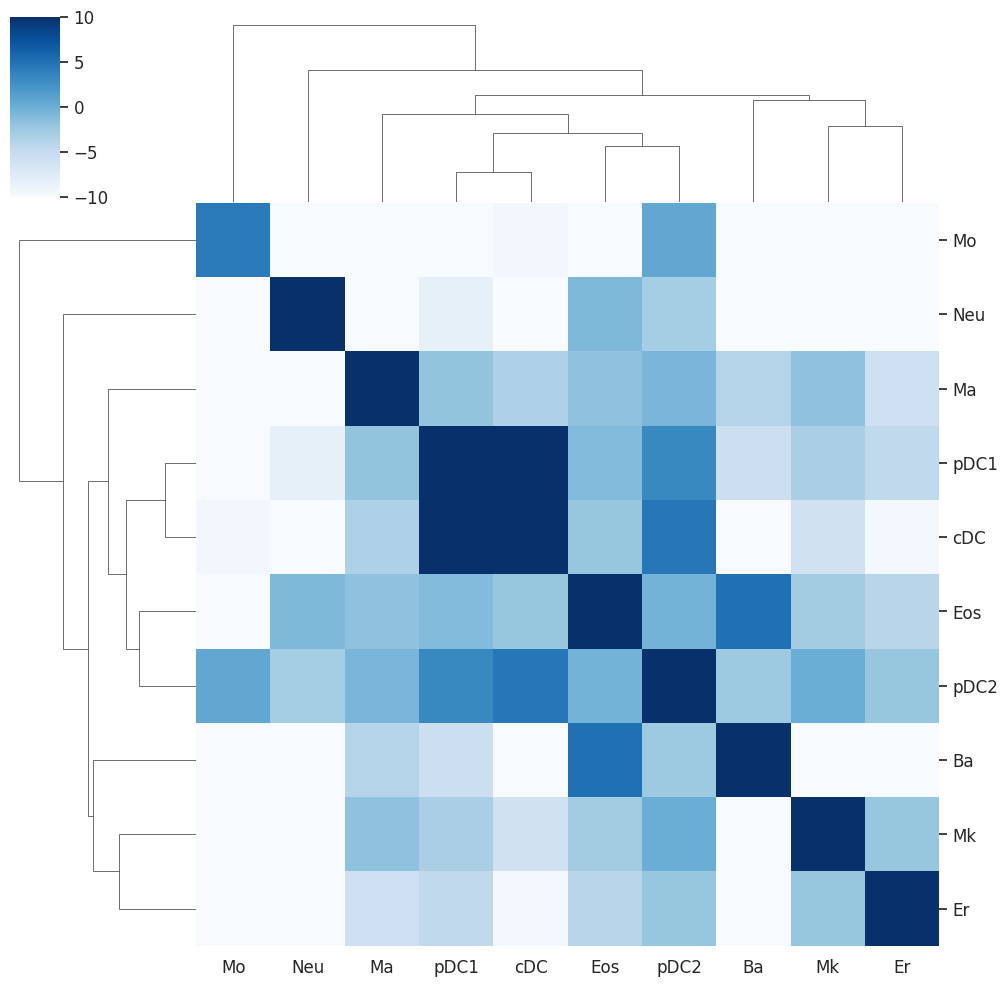

array_indexes[Ba] = 0
array_indexes[Ma] = 1
array_indexes[Mo] = 2
array_indexes[Neu] = 3
array_indexes[pDC1] = 4
array_indexes[cDC] = 5
array_indexes[Mk] = 6
array_indexes[Eos] = 7
array_indexes[Er] = 8
array_indexes[pDC2] = 9
Lineage Coupling Matrix:
    22.0     -3.9    -55.8    -27.7     -5.6    -10.8    -10.9      5.0    -21.7     -2.5 
    -3.9     35.4    -24.6    -12.1     -1.9     -3.5     -1.8     -1.8     -5.7     -0.7 
   -55.8    -24.6      4.3    -47.5    -10.1     -9.3    -36.7    -16.1    -50.7      0.6 
   -27.7    -12.1    -47.5     31.8     -8.2    -14.6    -16.8     -1.0    -30.0     -2.9 
    -5.6     -1.9    -10.1     -8.2     32.2     18.8     -3.2     -1.2     -4.6      3.2 
   -10.8     -3.5     -9.3    -14.6     18.8     25.1     -6.0     -2.2     -9.5      4.5 
   -10.9     -1.8    -36.7    -16.8     -3.2     -6.0     33.3     -2.8     -2.1      0.0 
     5.0     -1.8    -16.1     -1.0     -1.2     -2.2     -2.8     21.9     -4.1     -0.4 
   -21.7     -5.7   

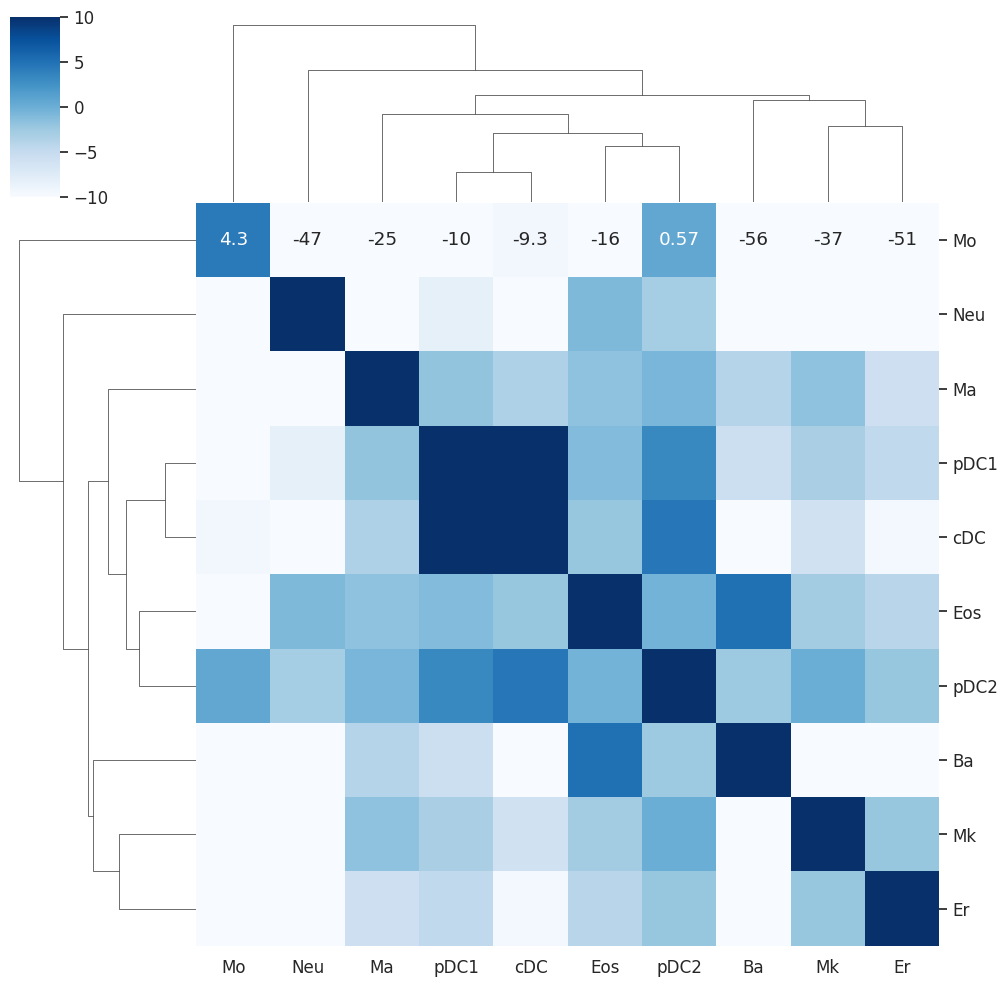

In [89]:
# --------------------------------------------
#  Hierarchical clustering
# --------------------------------------------
# may need to adjust the following parameters for a better viz
vmin = -10.0
vmax = 10.0

sns.set(font_scale=1.1)
output_dir = path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hc_clone_dist_wo_annot.png'

output_lineage_coupling_computations(
    cluster_pairs, clusters, clusters_names
    , csv_lineage_coupling_scores_matrix_output_file
    , vmin, vmax
    , output_dir
    , add_annot=False)

# w/ annotation on heatmap
output_dir = path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hc_clone_dist_w_annot.png'
output_lineage_coupling_computations(
    cluster_pairs, clusters, clusters_names
    , csv_lineage_coupling_scores_matrix_output_file
    , vmin, vmax
    , output_dir
    , add_annot=True)

In [90]:
path="/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/lineage_coupling_scores_matrix.csv"
clone_distance_matrix = pd.read_csv(path, index_col=0, header=0)

clone_distance_matrix.head(5)

,Ba,Ma,Mo,Neu,pDC1,cDC,Mk,Eos,Er,pDC2
ident_name,,,,,,,,,,
Ba,21.995258,-3.916267,-55.848173,-27.651114,-5.581714,-10.789565,-10.908736,5.030404,-21.670208,-2.479709
Ma,-3.916267,35.444385,-24.604252,-12.133412,-1.893885,-3.502471,-1.762724,-1.760795,-5.683921,-0.744547
Mo,-55.848173,-24.604252,4.327938,-47.458050,-10.068855,-9.301754,-36.728230,-16.093457,-50.704493,0.572728
Neu,-27.651114,-12.133412,-47.458050,31.794380,-8.209998,-14.595965,-16.768090,-0.953862,-29.951686,-2.933951
pDC1,-5.581714,-1.893885,-10.068855,-8.209998,32.226406,18.764681,-3.211523,-1.152263,-4.626697,3.195368


# 2-Hierarchical clustering on cell state

## 2.0 define cell state

In [91]:
adata

AnnData object with n_obs × n_vars = 58627 × 1994
    obs: 'Time point', 'Cell type annotation', 'Cytokine condition', 'SPRING-x', 'SPRING-y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cloneID', 'Mo_progenitor_cells', 'Ba_progenitor_cells', 'Ma_progenitor_cells', 'cDC_progenitor_cells', 'Neu_progenitor_cells', 'Mk_progenitor_cells', 'pDC1_progenitor_cells', 'Er_progenitor_cells', 'Eos_progenitor_cells', 'pDC2_progenitor_cells'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'SPRING coordinates'

In [92]:
# load adata
data_path = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/preprocessed_scRNA.h5ad'
adata = ad.read(data_path)

# remove undifferentiated cells
adata = adata[~adata.obs['Cell type annotation'].isin(['Undifferentiated']),:]  # create a view, not a copy

# avg of expression features over all cell types
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['Cell type annotation'].cat.categories) # result df
for c in adata.obs['Cell type annotation'].cat.categories:
    res.loc[c] = adata[adata.obs['Cell type annotation'].isin([c]),:].X.mean(0)

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [93]:
res

geneID,1700003I16Rik,1700006J14Rik,1700010I14Rik,1700020L24Rik,1700021F05Rik,1700030C10Rik,1700030N03Rik,1700047M11Rik,1700048O20Rik,1700109H08Rik,...,Zkscan14,Zmat1,Zmym6,Znrf3,Zranb3,Zrsr1,Zxdb,Zyx,a,mt-Nd6
Ba,-0.081438,0.003547,-0.027001,0.180277,-0.116553,0.009063,-0.043298,-0.059002,-0.023535,-0.061676,...,0.041896,-0.044201,-0.02715,-0.027013,-0.11735,-0.018273,0.066294,0.231429,-0.027262,-0.097711
Eos,-0.08385,0.020892,-0.013056,0.336291,-0.11272,-0.101522,0.002696,-0.061474,-0.059092,-0.118753,...,0.022121,0.001829,-0.124261,0.161157,-0.136381,-0.01521,0.009497,-0.367028,-0.060546,-0.073204
Er,-0.079813,0.093207,-0.04198,-0.28297,-0.007854,-0.022149,-0.02652,-0.057206,0.019804,-0.0119,...,0.059708,-0.038643,-0.041588,0.002673,-0.098422,0.417784,-0.053322,-0.331117,-0.058405,-0.043952
Ma,-0.083418,0.137968,0.066846,-0.25321,0.014356,-0.055371,-0.058368,-0.06087,-0.03187,-0.025336,...,0.005777,-0.017851,0.096481,0.01903,-0.10283,-0.061786,0.125015,-0.053205,-0.047275,-0.025898
Mk,-0.067364,0.001834,0.081198,-0.265868,-0.02259,-0.007608,-0.015152,-0.061733,-0.010184,-0.024871,...,0.023958,0.025773,-0.021693,-0.014475,-0.053616,-0.06109,-0.055026,1.629154,-0.05421,-0.002799
Mo,0.116747,-0.048921,-0.038964,-0.26142,0.05623,-0.045057,-0.015446,-0.0564,-0.035236,-0.049385,...,-0.043234,-0.02534,-0.026442,-0.041809,0.176833,-0.049788,-0.036738,-0.021802,-0.043929,-0.054821
Neu,-0.059913,-0.037513,0.048204,0.78944,-0.081284,-0.025812,-0.031056,0.23095,-0.041046,-0.049813,...,0.050417,0.003558,0.038998,-0.05428,-0.116949,0.028333,-0.009672,0.088014,-0.040003,-0.083098
cDC,-0.082177,-0.038806,-0.057924,-0.273869,-0.072999,-0.029949,-0.057326,-0.059137,-0.045075,-0.090031,...,-0.011826,0.073611,-0.027195,-0.064331,-0.131316,-0.104941,-0.052935,-0.169906,-0.032919,-0.054966
pDC1,-0.083905,-0.053591,-0.014185,-0.306983,-0.050987,-0.10149,-0.07191,-0.061551,-0.059074,-0.118766,...,0.009082,-0.0728,-0.104466,-0.062623,-0.045765,-0.069216,0.043539,-0.239947,0.08646,-0.077894
pDC2,-0.082336,-0.053397,-0.087221,-0.301575,-0.19222,0.063129,-0.071922,-0.059359,-0.059598,-0.118384,...,0.277934,-0.072398,-0.154913,-0.064174,-0.217954,-0.191385,-0.006142,-0.382845,-0.061979,-0.045011


## 2.1 Euclidean distance

In [96]:
# --------------------------------------
#  Gaussian kernel; adaptative bandwidth
# --------------------------------------
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
res_numeric = res.apply(pd.to_numeric, errors='coerce')
# distance matrix based on cell state
D = compute_distances(res_numeric.values)  # matrix: cell type x (avg) gene
A = compute_affinity_matrix(D, kernel_type="adaptive", k=5, sigma=None)

/tmp/ipykernel_610602/3045657373.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i][j]=0.5 *(np.exp(-D[i][j]**2/sigma[i]**2)+np.exp(-D[i][j]**2/sigma[j]**2))


In [97]:
D_df = pd.DataFrame(D, index=res.index, columns=res.index)
A_df = pd.DataFrame(A, index=res.index, columns=res.index)

In [98]:
D_df.head(5)

,Ba,Eos,Er,Ma,Mk,Mo,Neu,cDC,pDC1,pDC2
Ba,0.000000,21.282666,23.870888,24.346952,29.278168,20.730615,21.859748,27.899458,28.260588,28.427559
Eos,21.282666,0.000000,24.718165,29.880252,31.265541,23.301135,23.282343,29.634509,29.579264,29.468636
Er,23.870888,24.718165,0.000000,30.282947,27.476135,22.413403,23.671445,28.682111,28.726563,28.281723
Ma,24.346952,29.880252,30.282947,0.000000,34.386970,28.315686,30.473247,33.553295,34.506715,34.413670
Mk,29.278168,31.265541,27.476135,34.386970,0.000000,29.502720,30.506893,34.533489,34.527878,34.096165


In [99]:
A_df.head(5)

,Ba,Eos,Er,Ma,Mk,Mo,Neu,cDC,pDC1,pDC2
Ba,1.000000,0.529658,0.426257,0.448024,0.325776,0.470097,0.487573,0.318430,0.313907,0.309956
Eos,0.529658,1.000000,0.469986,0.370005,0.346157,0.452907,0.510418,0.343675,0.349747,0.352773
Er,0.426257,0.469986,1.000000,0.334637,0.414917,0.456632,0.474761,0.341924,0.345514,0.357254
Ma,0.448024,0.370005,0.334637,1.000000,0.289098,0.326335,0.328767,0.266459,0.251294,0.253414
Mk,0.325776,0.346157,0.414917,0.289098,1.000000,0.307102,0.337404,0.255659,0.260059,0.269104


## 2.2 diffusion distance

In [100]:
t = 5
import scipy.linalg as la
diff_vec, diff_eig = diff_map_info(A)
diff_map = get_diff_map(diff_vec, diff_eig, t=t)

In [101]:
diff_coords = diff_map[:,0:3]  # [cell type, coords (take first 3 coordinates here)]

In [102]:
diff_D = compute_distances(diff_coords)  # diffusion distance
diff_D = pd.DataFrame(diff_D, index=res.index, columns=res.index)

## 2.2 HC based on various distance

/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/db2423/.conda/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


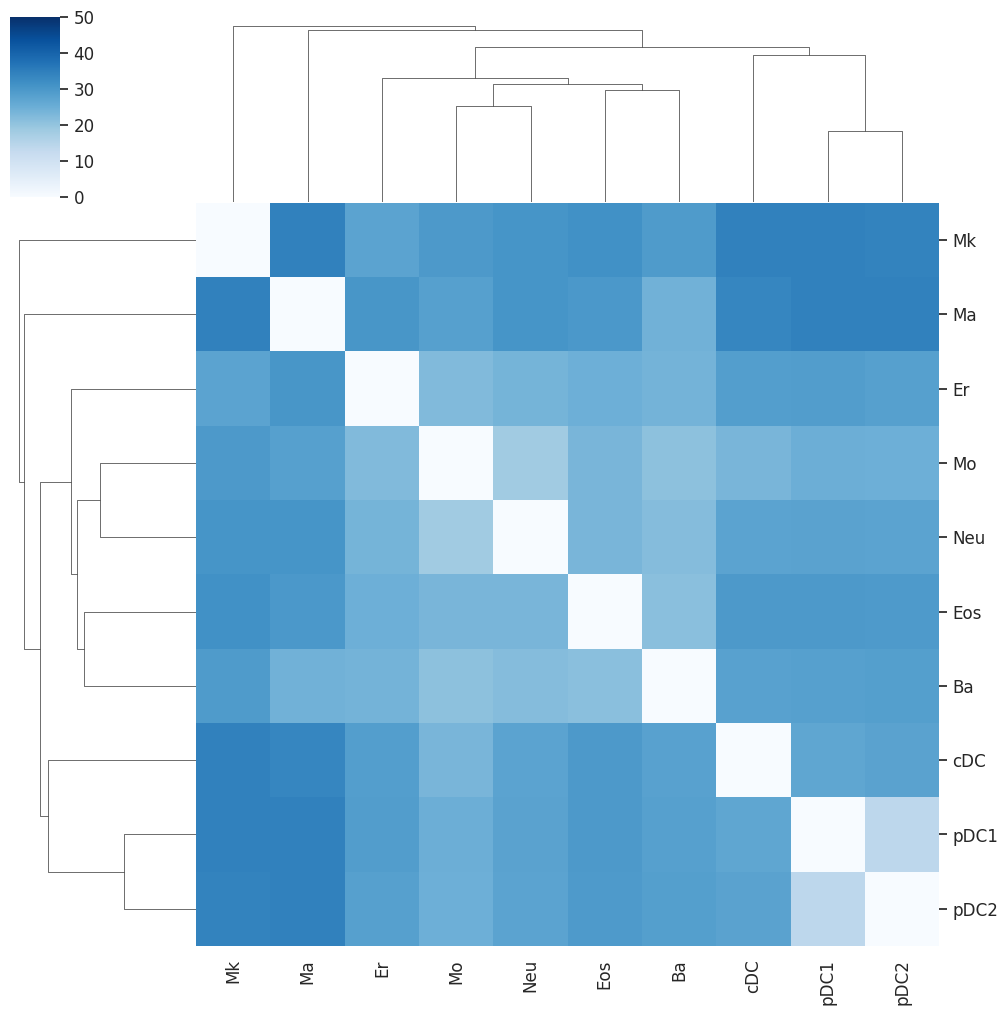

In [104]:
# Euclidean distance
vmin=0
vmax=50
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hc
desired_order = ['Mo', 'Neu', 'Ma', 'pDC1', 'cDC', 'Eos', 'pDC2', 'Ba', 'Mk', 'Er']

# Reindex the DataFrame according to the desired order for both rows and columns
D_df_ordered = D_df.reindex(index=desired_order, columns=desired_order)

# Plot the clustermap with the ordered DataFrame without hierarchical linkage
with sns.axes_style("white"):
    ax = sns.clustermap(D_df_ordered, cmap="Blues", vmin=vmin, vmax=vmax)
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)  # Rotate x-axis labels if needed

plt.show()

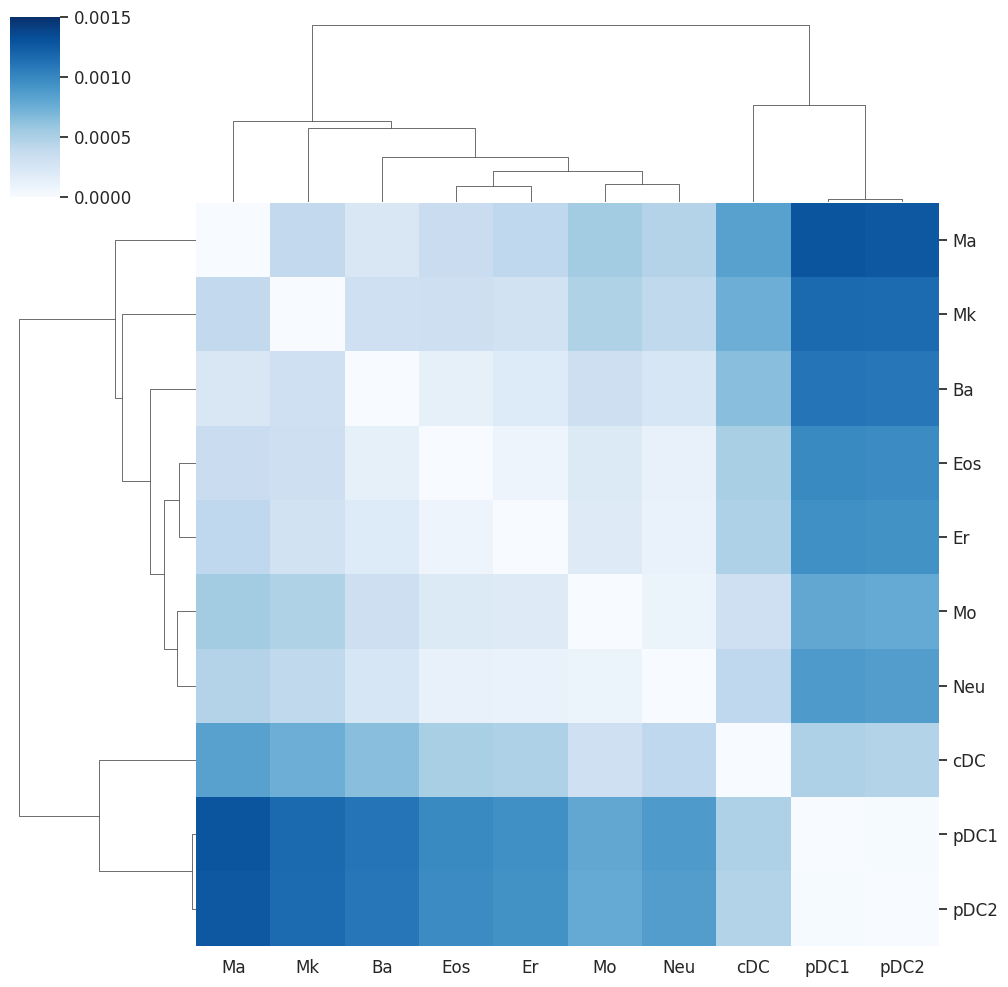

In [105]:
output_dir = '/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hc_diffusion_dist.png'

# diffusion distance
vmin=0
vmax=0.0015

squareform_distance = distance.squareform(diff_D.values)

# Perform hierarchical clustering
linkage = hc.linkage(squareform_distance, method='average')
with sns.axes_style("white"):
    ax = sns.clustermap(diff_D, row_linkage=linkage, col_linkage=linkage, cmap="Blues",
                        vmin=vmin, vmax=vmax)
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig(output_dir, dpi=300, bbox_inches="tight", format="png")
plt.show()

In [106]:
clone_distance_matrix

,Ba,Ma,Mo,Neu,pDC1,cDC,Mk,Eos,Er,pDC2
ident_name,,,,,,,,,,
Ba,21.995258,-3.916267,-55.848173,-27.651114,-5.581714,-10.789565,-10.908736,5.030404,-21.670208,-2.479709
Ma,-3.916267,35.444385,-24.604252,-12.133412,-1.893885,-3.502471,-1.762724,-1.760795,-5.683921,-0.744547
Mo,-55.848173,-24.604252,4.327938,-47.458050,-10.068855,-9.301754,-36.728230,-16.093457,-50.704493,0.572728
Neu,-27.651114,-12.133412,-47.458050,31.794380,-8.209998,-14.595965,-16.768090,-0.953862,-29.951686,-2.933951
pDC1,-5.581714,-1.893885,-10.068855,-8.209998,32.226406,18.764681,-3.211523,-1.152263,-4.626697,3.195368
cDC,-10.789565,-3.502471,-9.301754,-14.595965,18.764681,25.055888,-5.994139,-2.169077,-9.480397,4.530727
Mk,-10.908736,-1.762724,-36.728230,-16.768090,-3.211523,-5.994139,33.334629,-2.784956,-2.139575,0.003560
Eos,5.030404,-1.760795,-16.093457,-0.953862,-1.152263,-2.169077,-2.784956,21.855571,-4.140262,-0.445796
Er,-21.670208,-5.683921,-50.704493,-29.951686,-4.626697,-9.480397,-2.139575,-4.140262,14.356849,-2.116507


In [107]:
path="/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/diff_distance_matrix"
diff_D.to_csv(path)
diff_D_distance = pd.read_csv(path, index_col=0, header=0)

diff_D_distance.head(5)

,Ba,Eos,Er,Ma,Mk,Mo,Neu,cDC,pDC1,pDC2
Ba,0.000000,0.000130,0.000195,0.000230,0.000316,0.000328,0.000241,0.000639,0.001105,0.001090
Eos,0.000130,0.000000,0.000082,0.000350,0.000326,0.000202,0.000114,0.000515,0.000983,0.000968
Er,0.000195,0.000082,0.000000,0.000404,0.000292,0.000188,0.000109,0.000487,0.000948,0.000933
Ma,0.000230,0.000350,0.000404,0.000000,0.000392,0.000540,0.000460,0.000838,0.001283,0.001268
Mk,0.000316,0.000326,0.000292,0.000392,0.000000,0.000476,0.000400,0.000745,0.001172,0.001156


In [108]:
#Construct GNN

In [109]:
def z_scores_to_scaled_affinity(z_scores):
    # Apply exponential function to positive z-scores
    positive_affinities = np.exp(z_scores)
    positive_affinities[z_scores < 0] = 0

    # Apply scaled exponential function to negative z-scores
    # The scaling factor (e.g., 0.8) reduces the impact of negative z-scores
    negative_affinities = np.exp(-abs(z_scores)) * 0.8
    negative_affinities[z_scores >= 0] = 0

    # Combine positive and negative affinities
    affinities = positive_affinities + negative_affinities

    # Normalize the affinities so that they sum to 1 for each node
    affinity_sums = affinities.sum(axis=1)
    normalized_affinities = affinities / affinity_sums

    # Set the diagonal to zero if you don't want self-loops in the GNN
    np.fill_diagonal(normalized_affinities, 0)

    return normalized_affinities

In [110]:
def diffusion_to_affinity(diffusion_distance):
    # Apply an exponential decay to convert distances to affinities
    affinities = np.exp(-diffusion_distance)
    
    # Set the diagonal to zero if you don't want self-loops in the GNN
    np.fill_diagonal(affinities, 0)
    
    # Normalize the affinities so that they sum to 1 for each node
    affinity_sums = affinities.sum(axis=1)
    normalized_affinities = affinities / affinity_sums
    
    return normalized_affinities

In [111]:
clonal_affinity = z_scores_to_scaled_affinity(clone_distance_matrix.values)
diffusion_affinity = diffusion_to_affinity(diff_D_distance.values)

In [ ]:
# create Edge Index and Edge Weight Tensors

In [112]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [113]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [114]:
import torch
from torch_geometric.data import Data

def create_edge_index_and_weights(affinity_matrix):
    edge_index = []
    edge_weight = []
    
    for i, row in enumerate(affinity_matrix):
        for j, weight in enumerate(row):
            if i != j and weight > 0:  # Assuming no self-loops and positive weights
                edge_index.append((i, j))
                edge_weight.append(weight)
                
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    
    return edge_index, edge_weight

# Assume clonal_affinity and diffusion_affinity are numpy arrays from your affinity matrices
edge_index_clonal, edge_weight_clonal = create_edge_index_and_weights(clonal_affinity)
edge_index_diffusion, edge_weight_diffusion = create_edge_index_and_weights(diffusion_affinity)

In [115]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x  # Return embeddings

In [ ]:
# begin diffusion distance edge weight first 

In [116]:
from torch_geometric.data import Data

num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding

# Assuming edge_index_clonal and edge_weight_clonal are defined
data_diffusion = Data(x=node_features, edge_index=edge_index_diffusion, edge_attr=edge_weight_diffusion)

In [ ]:
edge_index_diffusion

In [118]:
from torch_geometric.utils import to_dense_adj


num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding
num_epochs = 200
num_runs = 3
final_losses = []

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index, data.edge_attr)
    reconstructed_adj = torch.sigmoid(torch.mm(embeddings, embeddings.t()))
    loss = F.mse_loss(reconstructed_adj, original_adj)
    loss.backward()
    optimizer.step()
    return loss.item()

for run in range(num_runs):
    # Reinitialize model and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNNModel(num_states, 64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data_diffusion.to(device)
    original_adj = to_dense_adj(data.edge_index, edge_attr=data.edge_attr)[0].to(device)

    for epoch in range(num_epochs):
        loss = train(model, data, optimizer)
        if epoch == num_epochs - 1:
            final_losses.append(loss)

# Calculate mean and standard deviation of losses
mean_loss = np.mean(final_losses)
std_loss = np.std(final_losses)

# Display the results in a table format
print(f"Run\tFinal Loss")
for i, loss in enumerate(final_losses):
    print(f"{i+1}\t{loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Std Deviation of Loss: {std_loss:.4f}")

Run	Final Loss
1	0.1611
2	0.1611
3	0.1611
Mean Loss: 0.1611
Std Deviation of Loss: 0.0000


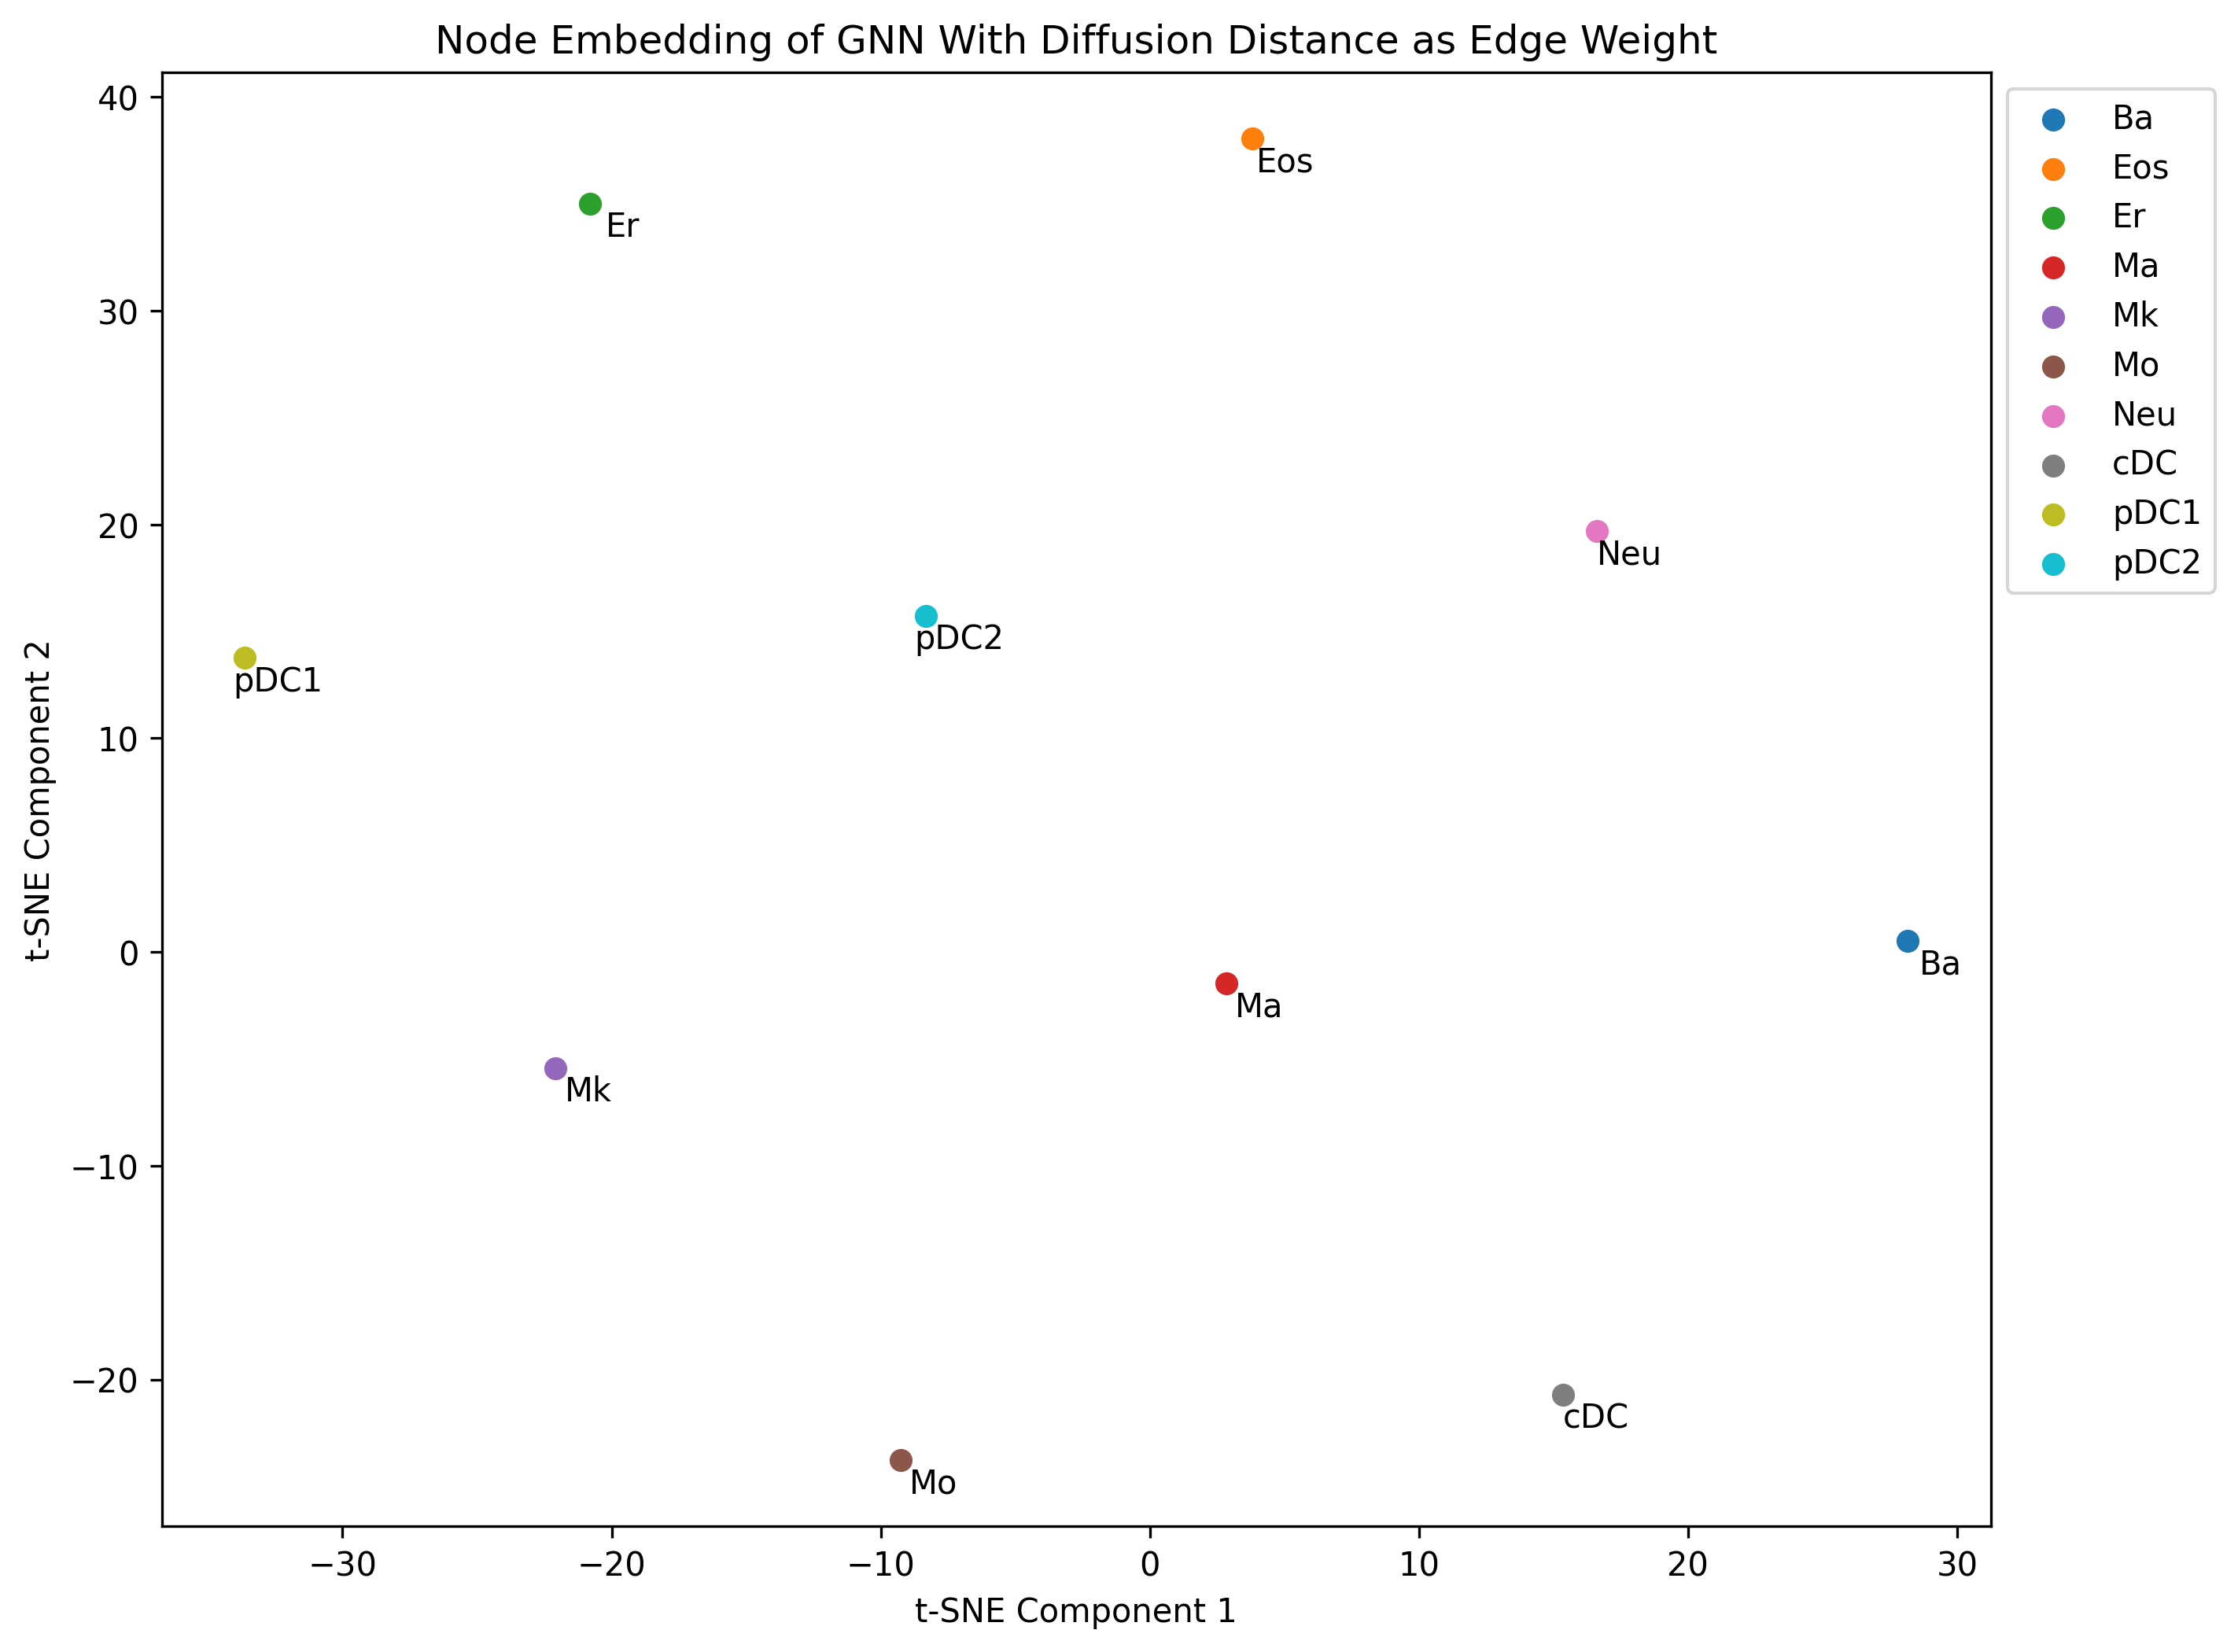

In [124]:
model.eval()
embeddings = model(data.x, data.edge_index, data.edge_attr).detach().cpu().numpy()
n_samples = embeddings.shape[0]

tsne_perplexity = min(30, n_samples - 1)
# t-SNE for visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


labels = ['Ba', 'Eos', 'Er', 'Ma', 'Mk', 'Mo', 'Neu', 'cDC', 'pDC1', 'pDC2']

plt.figure(figsize=(10, 8), dpi=300)
for i, label in enumerate(labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)

plt.title("Node Embedding of GNN With Diffusion Distance as Edge Weight")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Annotate the points with labels
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/tSNE_Node_Embedding_diffusion_distance.png', bbox_inches='tight')

plt.show()

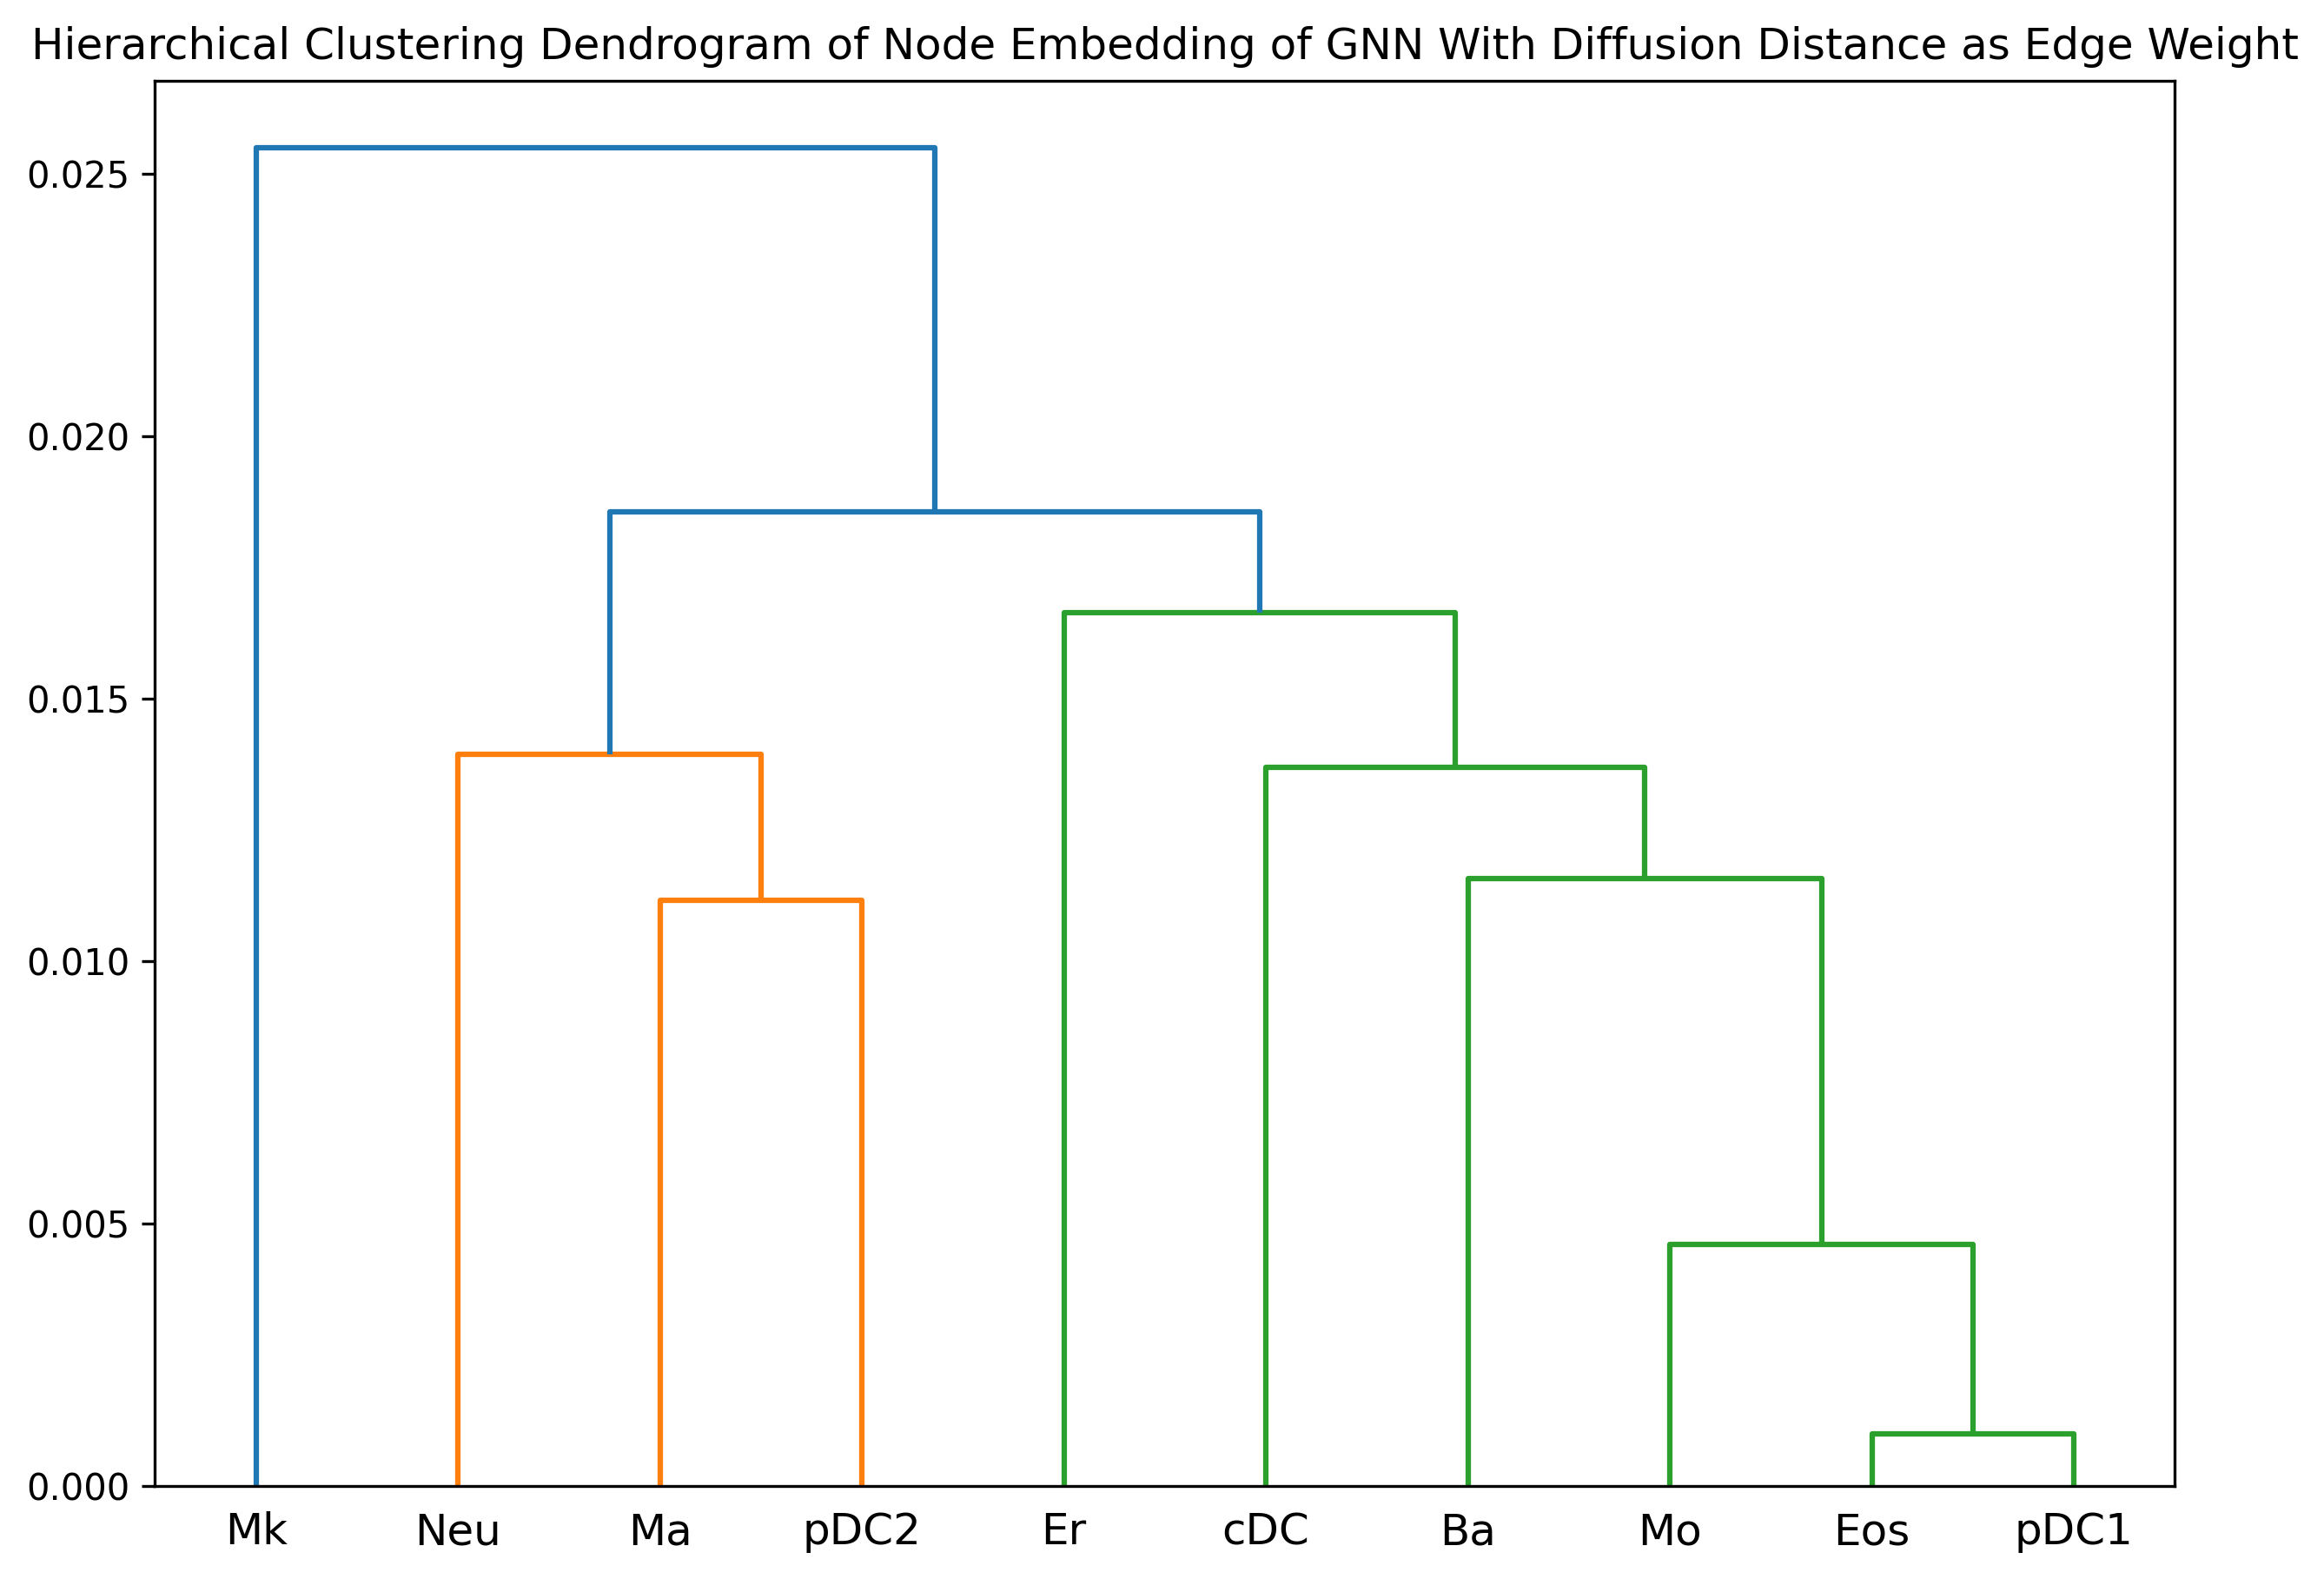

In [123]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(embeddings, 'average')
plt.figure(figsize=(10, 7),dpi=300)
dendrogram(linked, labels=labels, orientation='top')
plt.title('Hierarchical Clustering Dendrogram of Node Embedding of GNN With Diffusion Distance as Edge Weight')
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hierarchical_Node_Embedding_diffusion_distance_gnn.png', bbox_inches='tight')
plt.show()

In [ ]:
np.shape(edge_index_diffusion)

In [ ]:
np.shape(edge_weight_diffusion)

In [125]:
num_states = 10  # Number of nodes
node_features = torch.eye(num_states)  # One-hot encoding of node features

# Initialize the edge weight matrix with zeros
edge_weight_matrix = torch.zeros((num_states, num_states), dtype=torch.float)

# Fill in the edge weights based on the edge_index_diffusion and edge_weight_diffusion
for i in range(edge_index_diffusion.size(1)):
    src, dest = edge_index_diffusion[:, i].tolist()
    weight = edge_weight_diffusion[i].item()
    edge_weight_matrix[src, dest] = weight

# Since we don't want self-loops, we can ensure the diagonal is zero.
# This is optional because the diagonal of node_features is already 1 and won't be affected by adding zeros.
for i in range(num_states):
    edge_weight_matrix[i, i] = 0

# Augment node features by concatenating with the edge weight matrix
augmented_node_features = torch.cat([node_features, edge_weight_matrix], dim=1)

# Create the PyG Data object with the augmented node features
data = Data(x=augmented_node_features, edge_index=edge_index_diffusion)


In [139]:
from torch_geometric.nn import GATConv

# Define the GAT model
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding
num_epochs = 200
num_runs = 3
final_losses = []
# Define the training loop
def train(model,data,optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # Since we don't have labels, we might use unsupervised loss here; e.g., reconstructing the diffusion matrix
    reconstructed_diffusion_matrix = torch.sigmoid(torch.mm(out, out.t()))
    mask = torch.ones_like(reconstructed_diffusion_matrix) - torch.eye(num_states, device=device)
    reconstructed_diffusion_matrix_off_diag = reconstructed_diffusion_matrix * mask
    edge_weight_matrix_off_diag = edge_weight_matrix * mask
    loss = F.mse_loss(reconstructed_diffusion_matrix_off_diag, edge_weight_matrix_off_diag)
    loss.backward()
    optimizer.step()
    return loss.item()

for run in range(num_runs):
    # Reinitialize model and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = augmented_node_features.shape[1]
    model = GATModel(input_dim=input_dim, hidden_dim=64, heads=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data.to(device)
    
    for epoch in range(num_epochs):
        loss = train(model, data, optimizer)
        if epoch == num_epochs - 1:
            final_losses.append(loss)

# Calculate mean and standard deviation of losses
mean_loss = np.mean(final_losses)
std_loss = np.std(final_losses)

# Display the results in a table format
print(f"Run\tFinal Loss")
for i, loss in enumerate(final_losses):
    print(f"{i+1}\t{loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Std Deviation of Loss: {std_loss:.4f}")

Run	Final Loss
1	0.1411
2	0.1397
3	0.1434
Mean Loss: 0.1414
Std Deviation of Loss: 0.0015


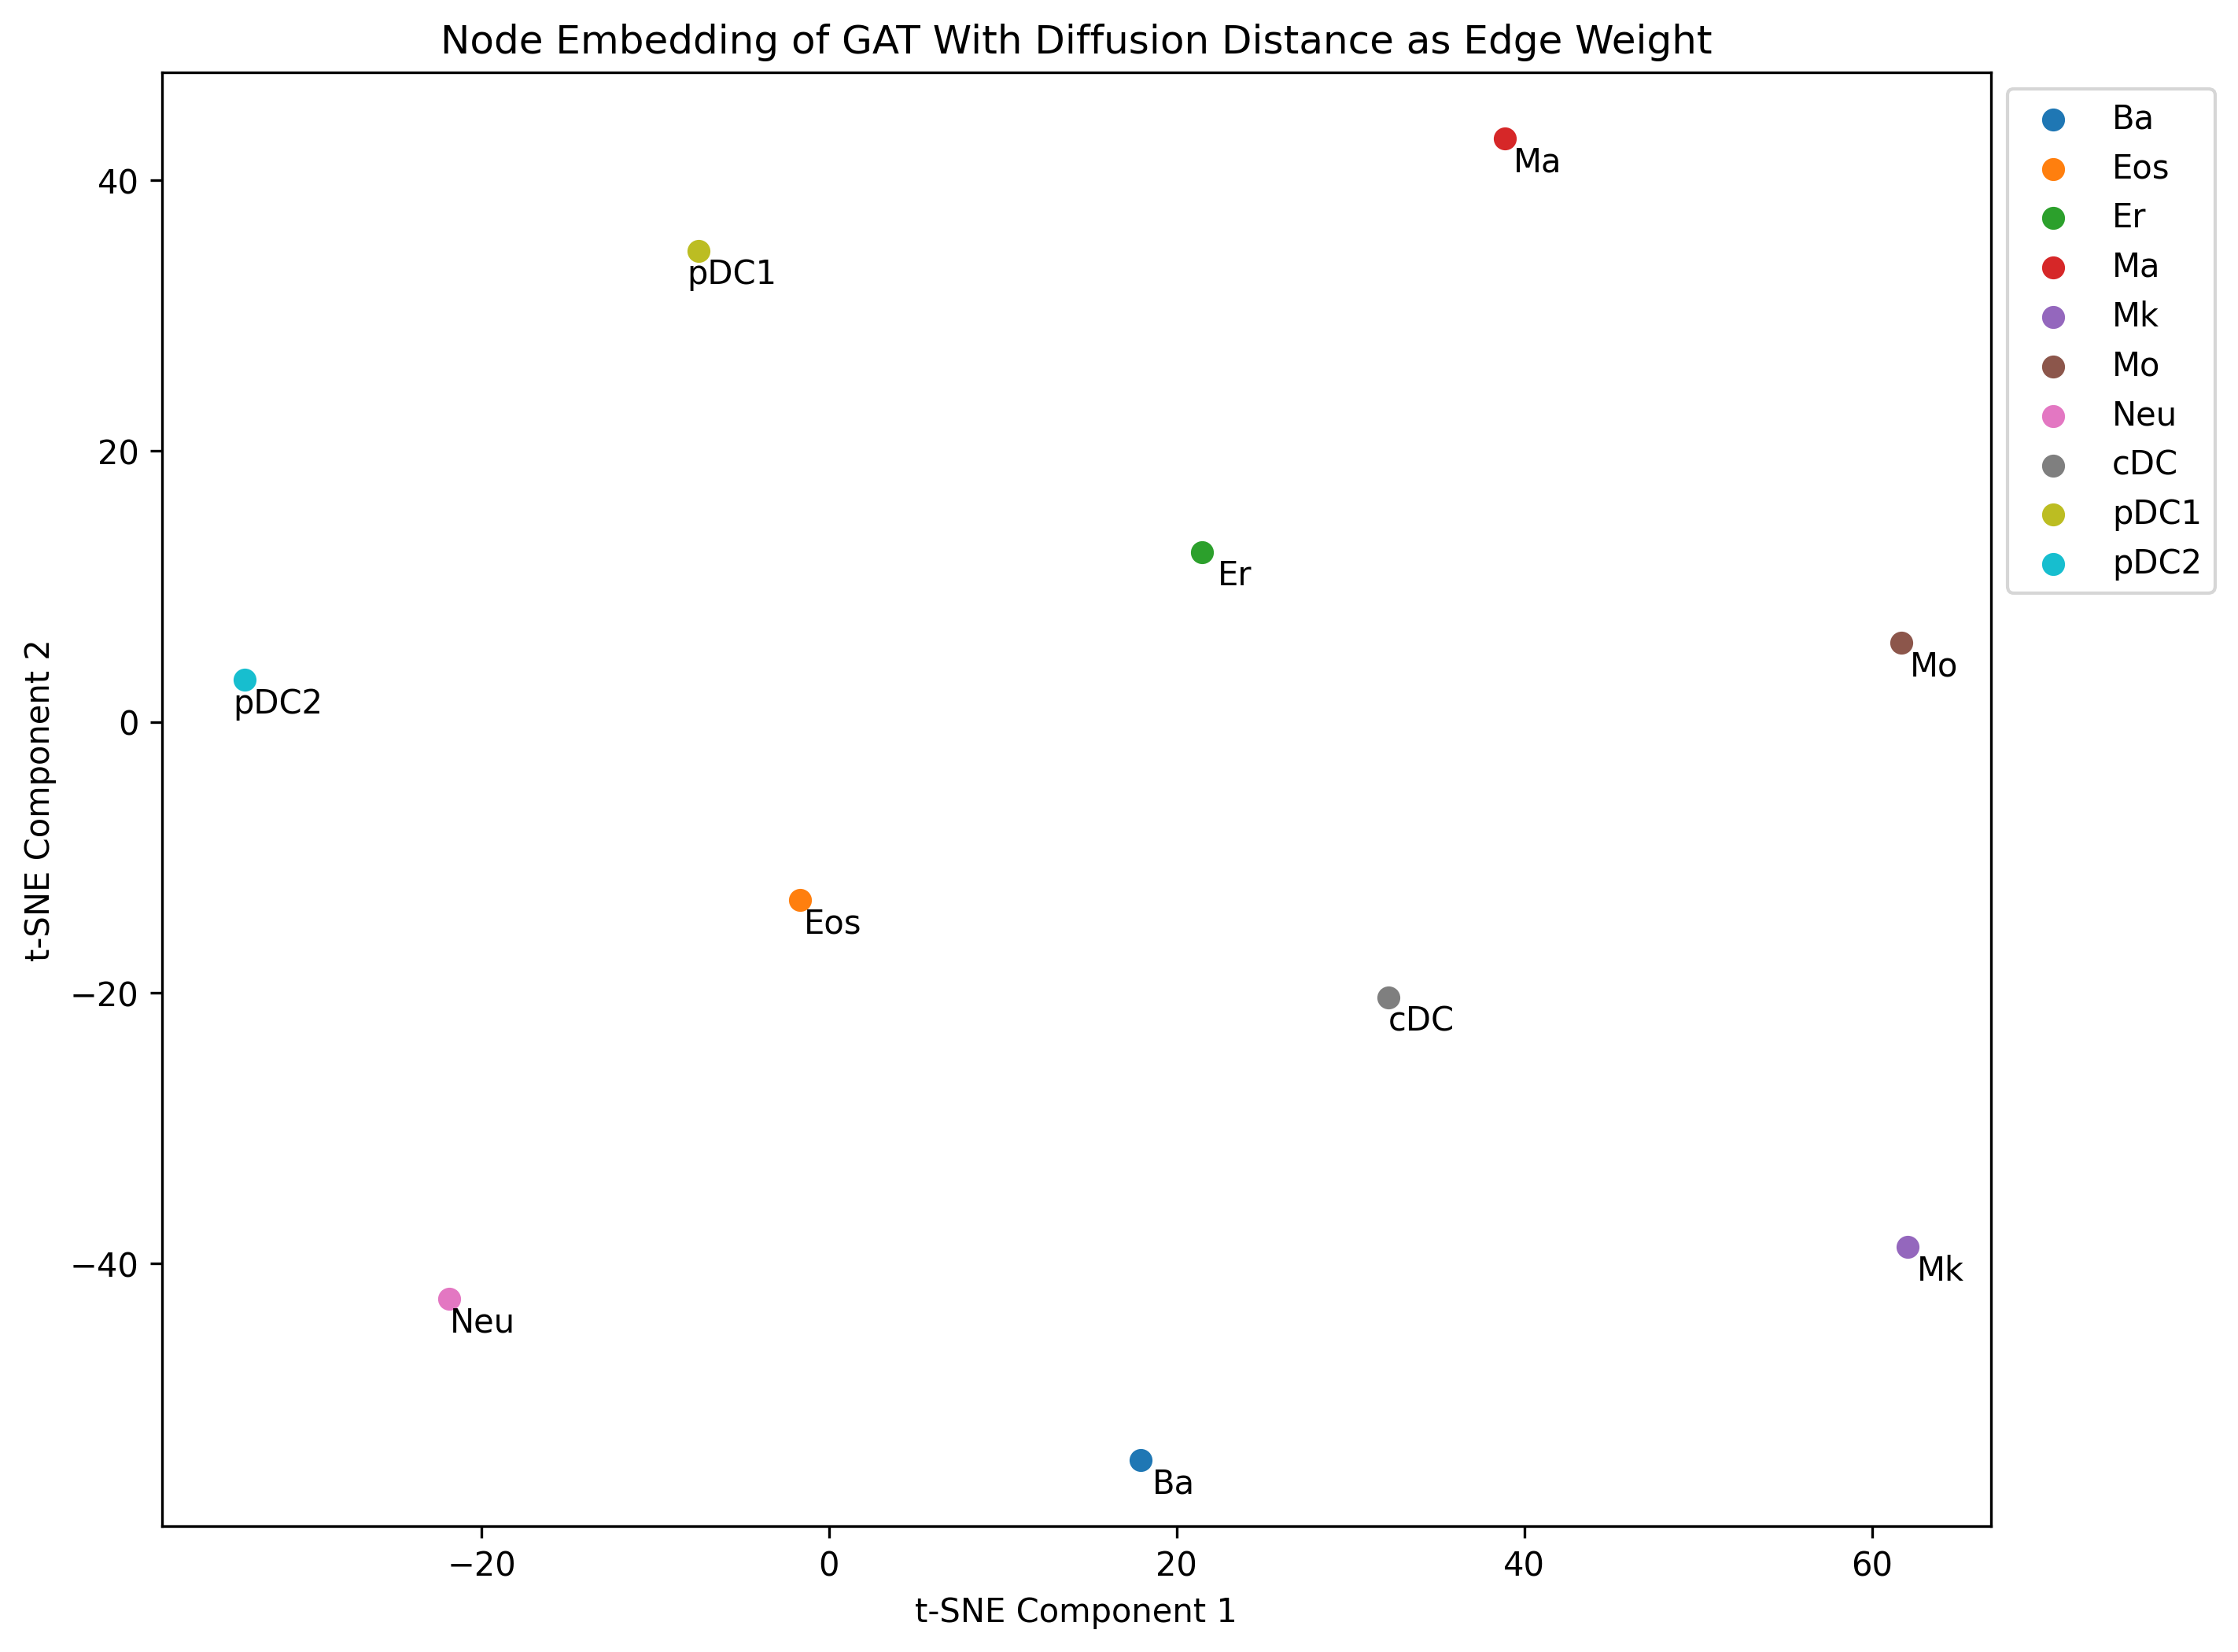

In [130]:
model.eval()
embeddings = model(data.x, data.edge_index).detach().cpu().numpy()
n_samples = embeddings.shape[0]

tsne_perplexity = min(30, n_samples - 1)
# t-SNE for visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


labels = ['Ba', 'Eos', 'Er', 'Ma', 'Mk', 'Mo', 'Neu', 'cDC', 'pDC1', 'pDC2']

plt.figure(figsize=(10, 8), dpi=300)
for i, label in enumerate(labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)

plt.title("Node Embedding of GAT With Diffusion Distance as Edge Weight")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Annotate the points with labels
for i, label in enumerate(labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/tSNE_Node_Embedding_diffusion_distance_gat.png', bbox_inches='tight')

plt.show()

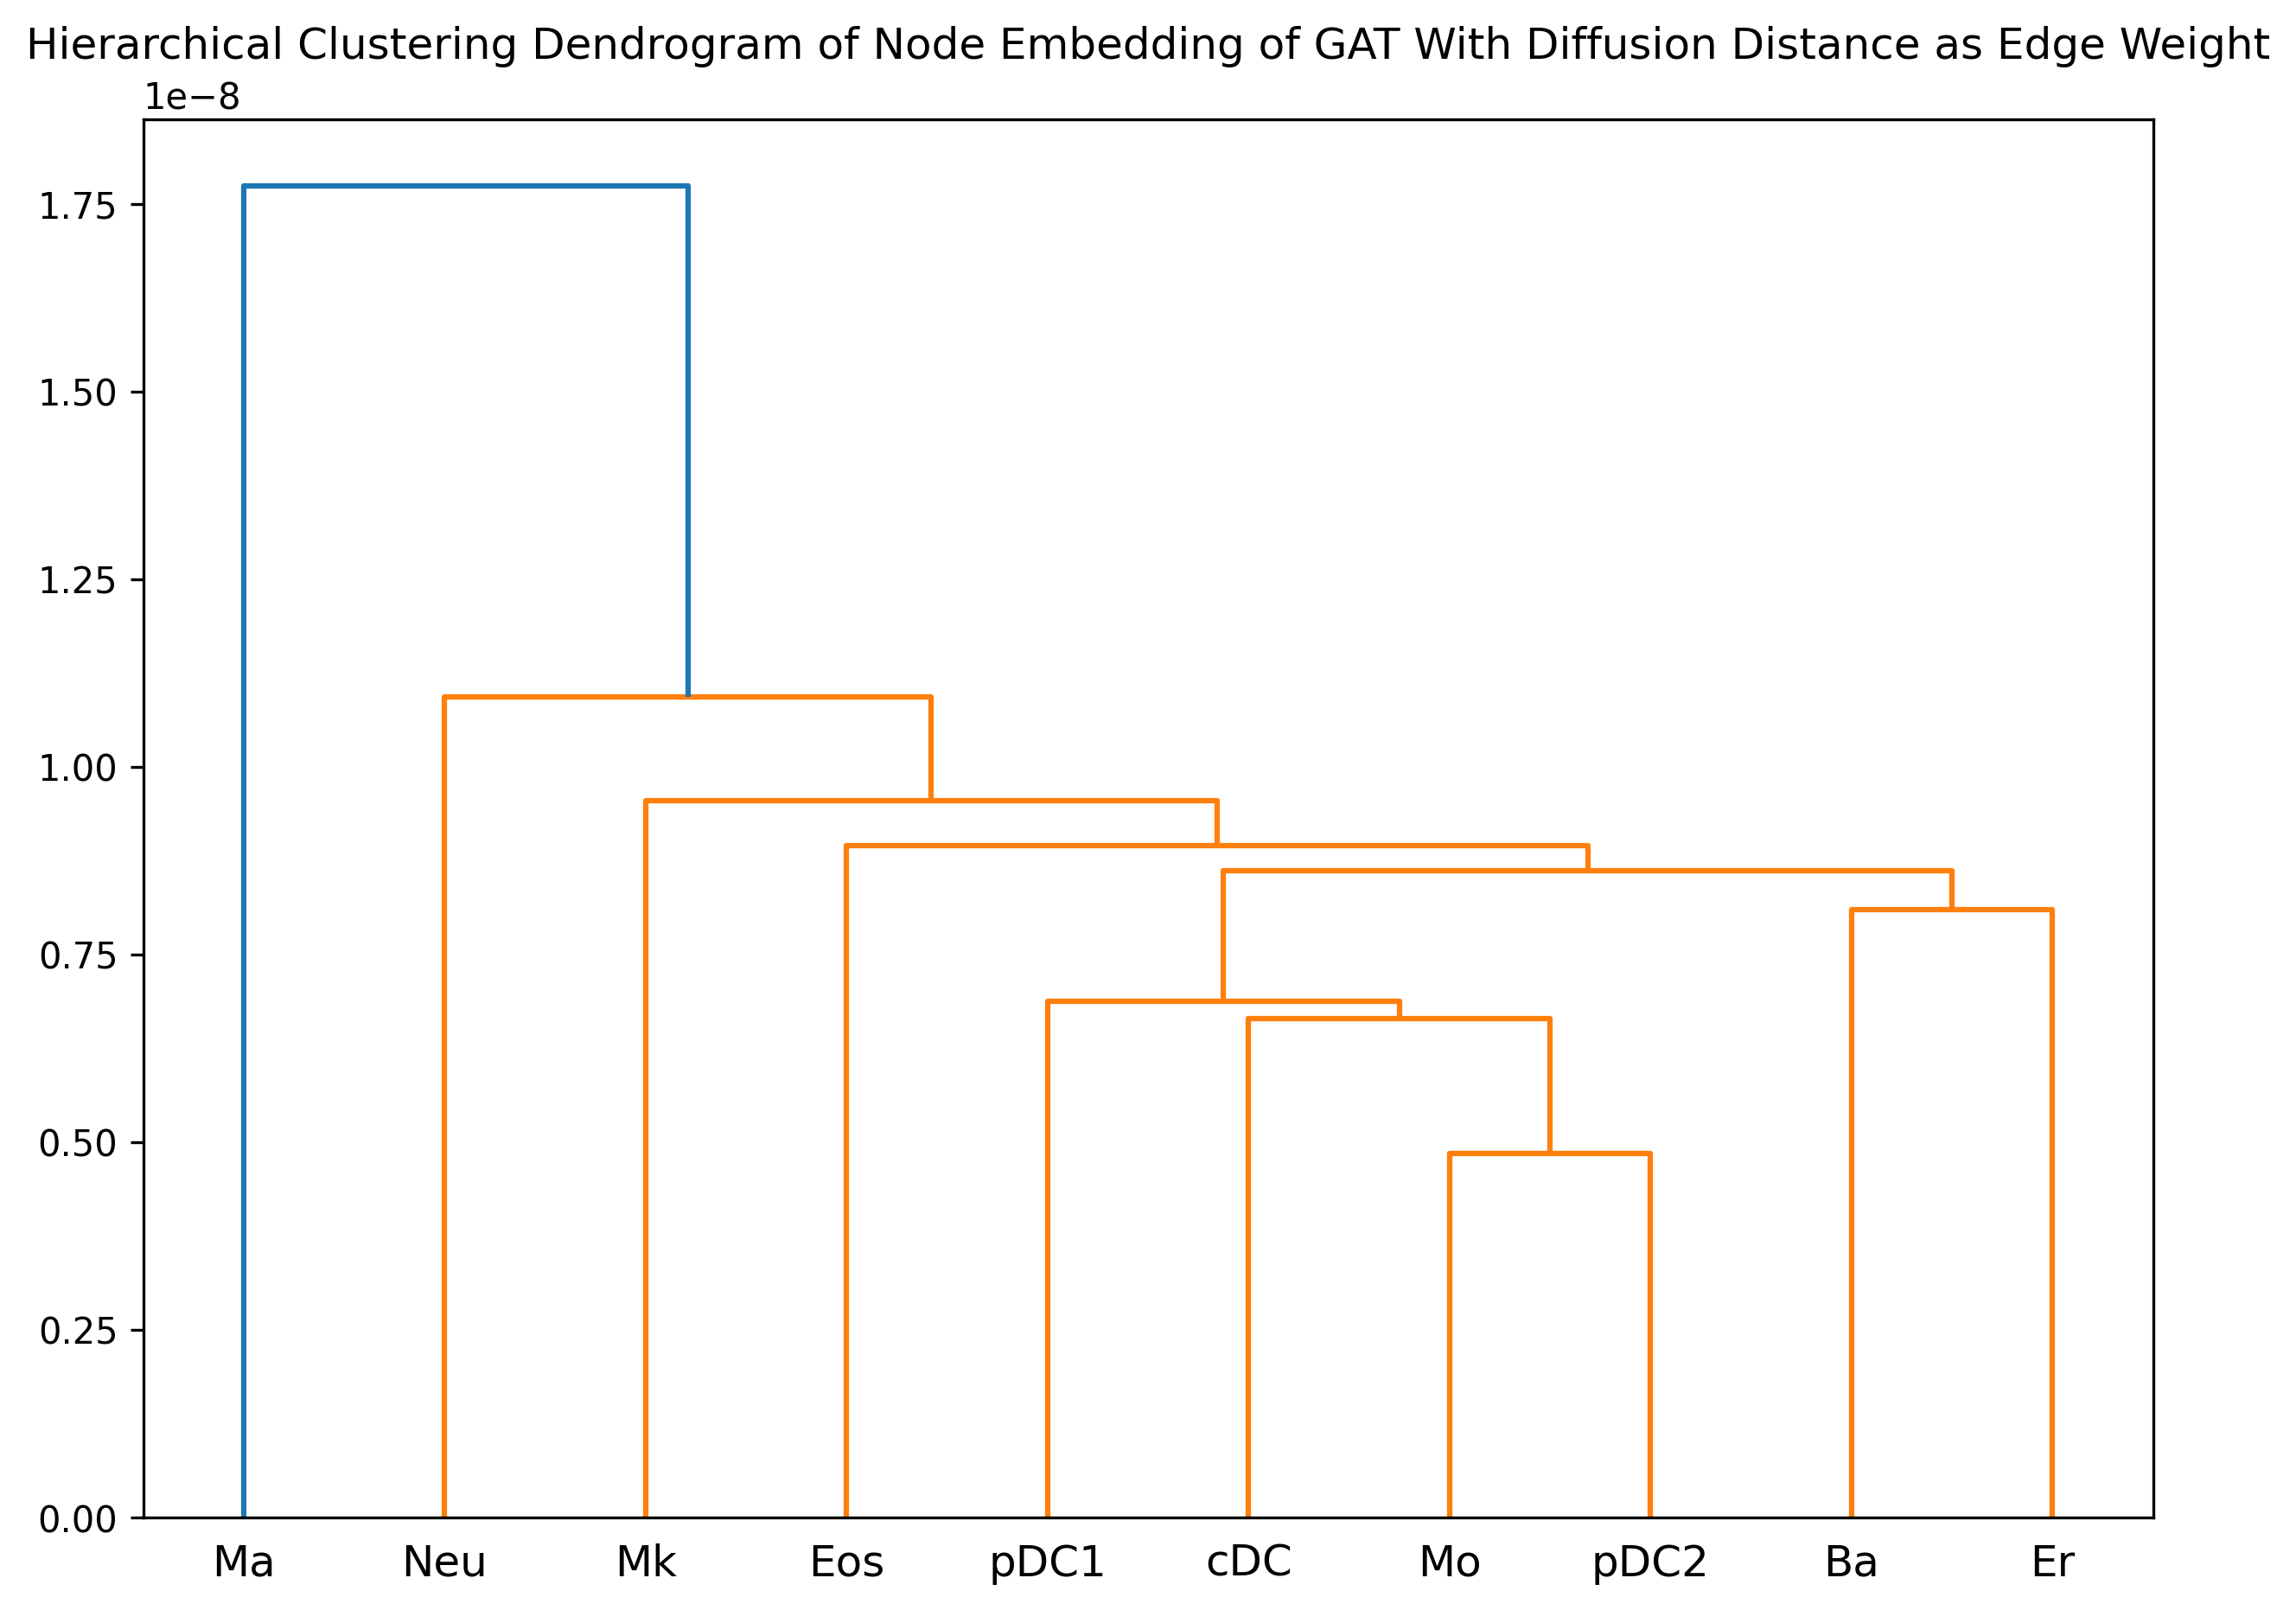

In [131]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(embeddings, 'average')
plt.figure(figsize=(10, 7),dpi=300)
dendrogram(linked, labels=labels, orientation='top')
plt.title('Hierarchical Clustering Dendrogram of Node Embedding of GAT With Diffusion Distance as Edge Weight')
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hierarchical_Node_Embedding_diffusion_distance_gat.png', bbox_inches='tight')
plt.show()


In [ ]:
# clonal distance gnn

In [140]:
from torch_geometric.data import Data

num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding

# Assuming edge_index_clonal and edge_weight_clonal are defined
data_clonal= Data(x=node_features, edge_index=edge_index_clonal, edge_attr=edge_weight_clonal)

from torch_geometric.utils import to_dense_adj


num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding
num_epochs = 200
num_runs = 3
final_losses = []

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index, data.edge_attr)
    reconstructed_adj = torch.sigmoid(torch.mm(embeddings, embeddings.t()))
    loss = F.mse_loss(reconstructed_adj, original_adj)
    loss.backward()
    optimizer.step()
    return loss.item()

for run in range(num_runs):
    # Reinitialize model and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNNModel(num_states, 64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data_clonal.to(device)
    original_adj = to_dense_adj(data.edge_index, edge_attr=data.edge_attr)[0].to(device)

    for epoch in range(num_epochs):
        loss = train(model, data, optimizer)
        if epoch == num_epochs - 1:
            final_losses.append(loss)

# Calculate mean and standard deviation of losses
mean_loss = np.mean(final_losses)
std_loss = np.std(final_losses)

# Display the results in a table format
print(f"Run\tFinal Loss")
for i, loss in enumerate(final_losses):
    print(f"{i+1}\t{loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Std Deviation of Loss: {std_loss:.4f}")

Run	Final Loss
1	0.2498
2	0.2498
3	0.2498
Mean Loss: 0.2498
Std Deviation of Loss: 0.0000


In [141]:
# clonal distance gat
num_states = 10  # Number of nodes
node_features = torch.eye(num_states)  # One-hot encoding of node features

# Initialize the edge weight matrix with zeros
edge_weight_matrix = torch.zeros((num_states, num_states), dtype=torch.float)

# Fill in the edge weights based on the edge_index_diffusion and edge_weight_diffusion
for i in range(edge_index_clonal.size(1)):
    src, dest = edge_index_clonal[:, i].tolist()
    weight = edge_weight_clonal[i].item()
    edge_weight_matrix[src, dest] = weight

# Since we don't want self-loops, we can ensure the diagonal is zero.
# This is optional because the diagonal of node_features is already 1 and won't be affected by adding zeros.
for i in range(num_states):
    edge_weight_matrix[i, i] = 0

# Augment node features by concatenating with the edge weight matrix
augmented_node_features = torch.cat([node_features, edge_weight_matrix], dim=1)

# Create the PyG Data object with the augmented node features
data = Data(x=augmented_node_features, edge_index=edge_index_clonal)

from torch_geometric.nn import GATConv

# Define the GAT model
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

num_states = 10  # Adjust based on your data
node_features = torch.eye(num_states)  # One-hot encoding
num_epochs = 200
num_runs = 3
final_losses = []
# Define the training loop
def train(model,data,optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # Since we don't have labels, we might use unsupervised loss here; e.g., reconstructing the diffusion matrix
    reconstructed_clonal_matrix = torch.sigmoid(torch.mm(out, out.t()))
    mask = torch.ones_like(reconstructed_clonal_matrix) - torch.eye(num_states, device=device)
    reconstructed_clonal_matrix_off_diag = reconstructed_clonal_matrix * mask
    edge_weight_matrix_off_diag = edge_weight_matrix * mask
    loss = F.mse_loss(reconstructed_clonal_matrix_off_diag, edge_weight_matrix_off_diag)
    loss.backward()
    optimizer.step()
    return loss.item()

for run in range(num_runs):
    # Reinitialize model and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = augmented_node_features.shape[1]
    model = GATModel(input_dim=input_dim, hidden_dim=64, heads=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data.to(device)
    
    for epoch in range(num_epochs):
        loss = train(model, data, optimizer)
        if epoch == num_epochs - 1:
            final_losses.append(loss)

# Calculate mean and standard deviation of losses
mean_loss = np.mean(final_losses)
std_loss = np.std(final_losses)

# Display the results in a table format
print(f"Run\tFinal Loss")
for i, loss in enumerate(final_losses):
    print(f"{i+1}\t{loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Std Deviation of Loss: {std_loss:.4f}")

Run	Final Loss
1	0.2295
2	0.2275
3	0.2319
Mean Loss: 0.2296
Std Deviation of Loss: 0.0018


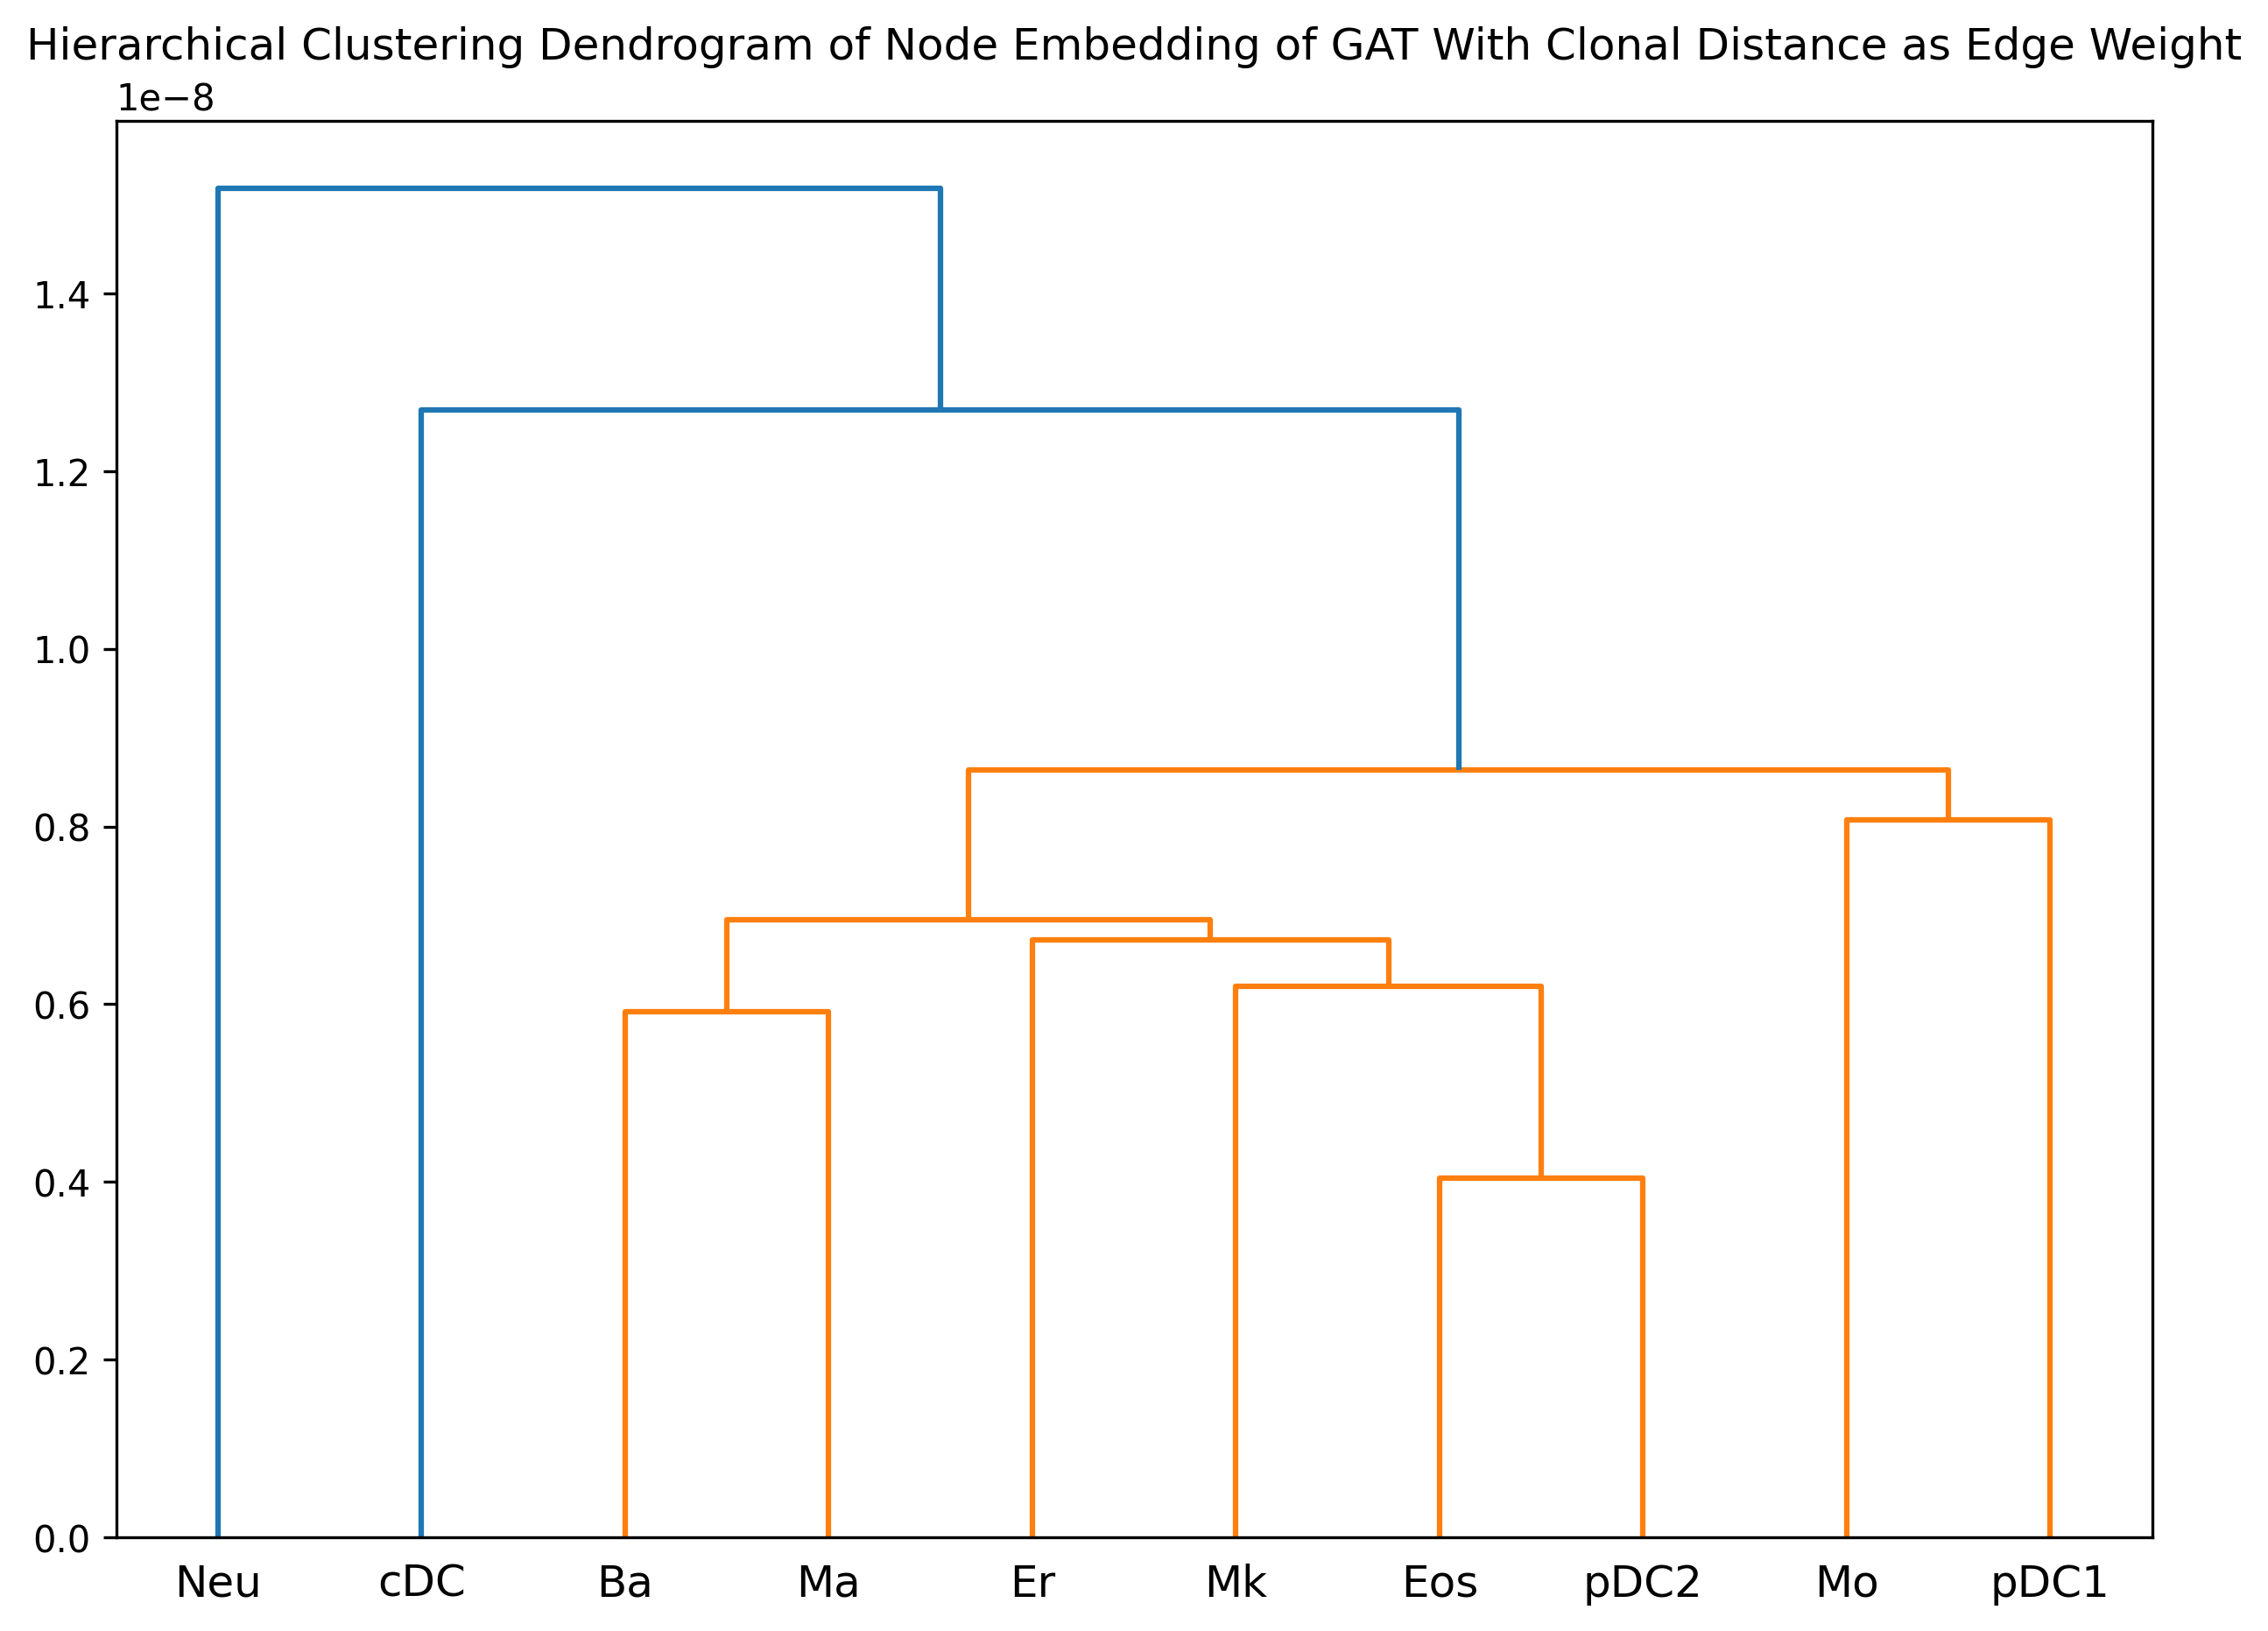

In [143]:
model.eval()
embeddings_clonal = model(data.x, data.edge_index).detach().cpu().numpy()
linked = linkage(embeddings_clonal, 'average')
plt.figure(figsize=(10, 7),dpi=300)
labels = ['Ba', 'Ma', 'Mo', 'Neu', 'pDC1', 'cDC', 'Mk', 'Eos', 'Er', 'pDC2']
dendrogram(linked, labels=labels, orientation='top')
plt.title('Hierarchical Clustering Dendrogram of Node Embedding of GAT With Clonal Distance as Edge Weight')
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/hierarchical_Node_Embedding_clonal_distance_gat.png', bbox_inches='tight')
plt.show()

In [188]:
distances = pdist(embeddings_clonal, metric='euclidean')

# Convert to a square form distance matrix
distance_matrix = squareform(distances)

# Apply an exponential decay to the distance matrix to get similarity
# Adjust the scale of the decay to your preference
decay_factor = 1.0  # This is an arbitrary scale factor for the decay
ajacency_matrix = np.exp(-decay_factor * distance_matrix)


# Create a graph from the adjacency matrix

G = nx.from_numpy_array(adjacency_matrix)
isolated_nodes = list(nx.isolates(G))

# If you have isolated nodes, you might choose to connect them with a small value
# or handle them in a domain-specific manner
for node in isolated_nodes:
    # Connect isolated nodes with a small value or handle otherwise
    # Example: Connect all isolated nodes to node 0 with a small similarity value
    G.add_edge(node, 0, weight=0)

# Calculate the clustering coefficient for the entire network
clustering_coefficients = nx.clustering(G)
average_clustering_coefficient = nx.average_clustering(G)

# Calculate the shortest path lengths for all pairs of nodes
shortest_path_lengths = dict(nx.floyd_warshall(G))


In [189]:
shortest_path_lengths

{0: defaultdict(<function networkx.algorithms.shortest_paths.dense.floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda>()>,
             {0: 0, 1: 1, 6: 1, 7: 1, 8: 1, 9: 1, 2: 0, 3: 0, 5: 0, 4: 2}),
 1: defaultdict(<function networkx.algorithms.shortest_paths.dense.floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda>()>,
             {1: 0, 0: 1, 8: 1, 9: 1, 2: 1, 3: 1, 4: 3, 5: 1, 6: 2, 7: 2}),
 2: defaultdict(<function networkx.algorithms.shortest_paths.dense.floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda>()>,
             {2: 0, 0: 0, 1: 1, 3: 0, 4: 2, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}),
 3: defaultdict(<function networkx.algorithms.shortest_paths.dense.floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda>()>,
             {3: 0, 0: 0, 1: 1, 2: 0, 4: 2, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}),
 4: defaultdict(<function networkx.algorithms.shortest_paths.dense.floyd_warshall_predecessor_and_distance.<

In [190]:
clustering_coeffs.values()

dict_values([0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 1.0, 0.3333333333333333])

In [191]:
average_clustering_coefficient

0.44857142857142857

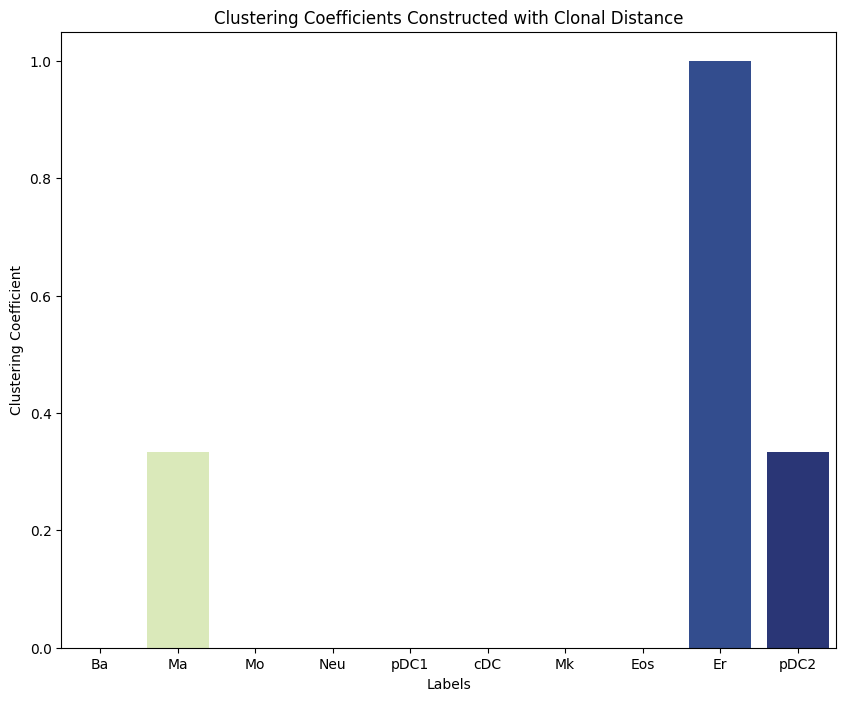

In [197]:

labels = ['Ba', 'Ma', 'Mo', 'Neu', 'pDC1', 'cDC', 'Mk', 'Eos', 'Er', 'pDC2']
# Create a DataFrame for plotting
df = pd.DataFrame({
    'Clustering Coefficient': clustering_coeffs.values(),
    'Cell States': labels
})

# Set the plot size
plt.figure(figsize=(10, 8))

# Create the bar plot
sns.barplot(x='Cell States', y='Clustering Coefficient', data=df, palette="YlGnBu")

# Set the title and labels
plt.title('Clustering Coefficients Constructed with Clonal Distance')
plt.xlabel('Labels')
plt.ylabel('Clustering Coefficient')

# Save the figure with a DPI of 300
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/clustering_coefficients_clonal_distance.png', dpi=300)

# Show the plot
plt.show()

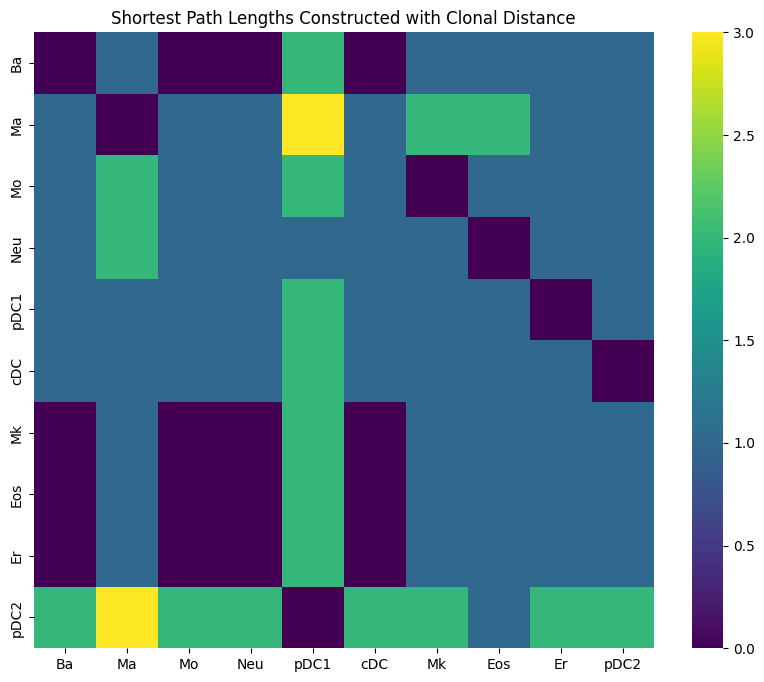

In [198]:
# The labels for each coefficient
path_lengths_df = pd.DataFrame(shortest_path_lengths)

# Define the labels for the axes

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(path_lengths_df, cmap="viridis", xticklabels=labels, yticklabels=labels)

# Add the title
plt.title("Shortest Path Lengths Constructed with Clonal Distance")

# Save the figure with a DPI of 300
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/shortest_path_lengths_heatmap_clonal.png', dpi=300)

# Display the plot
plt.show()

In [199]:
#diffusion distance
distances = pdist(embeddings, metric='euclidean')

# Convert to a square form distance matrix
distance_matrix = squareform(distances)

# Apply an exponential decay to the distance matrix to get similarity
# Adjust the scale of the decay to your preference
decay_factor = 1.0  # This is an arbitrary scale factor for the decay
ajacency_matrix = np.exp(-decay_factor * distance_matrix)


# Create a graph from the adjacency matrix

G = nx.from_numpy_array(adjacency_matrix)
isolated_nodes = list(nx.isolates(G))

# If you have isolated nodes, you might choose to connect them with a small value
# or handle them in a domain-specific manner
for node in isolated_nodes:
    # Connect isolated nodes with a small value or handle otherwise
    # Example: Connect all isolated nodes to node 0 with a small similarity value
    G.add_edge(node, 0, weight=0)

# Calculate the clustering coefficient for the entire network
clustering_coefficients = nx.clustering(G)
average_clustering_coefficient = nx.average_clustering(G)

# Calculate the shortest path lengths for all pairs of nodes
shortest_path_lengths = dict(nx.floyd_warshall(G))

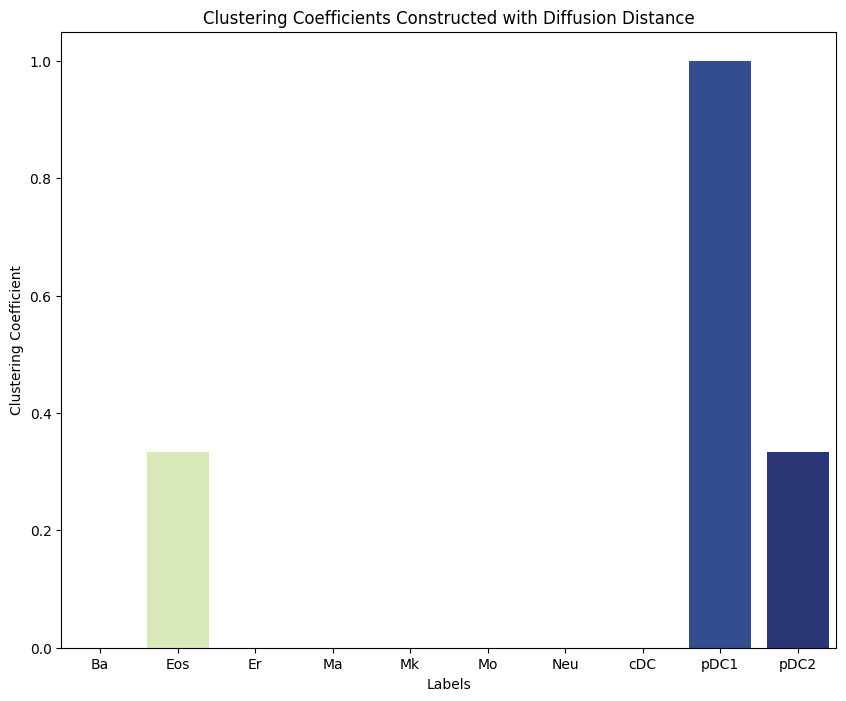

In [201]:
# Create a DataFrame for plotting
labels = ['Ba', 'Eos', 'Er', 'Ma', 'Mk', 'Mo', 'Neu', 'cDC', 'pDC1', 'pDC2']
df = pd.DataFrame({
    'Clustering Coefficient': clustering_coeffs.values(),
    'Cell States': labels
})

# Set the plot size
plt.figure(figsize=(10, 8))

# Create the bar plot
sns.barplot(x='Cell States', y='Clustering Coefficient', data=df, palette="YlGnBu")

# Set the title and labels
plt.title('Clustering Coefficients Constructed with Diffusion Distance')
plt.xlabel('Labels')
plt.ylabel('Clustering Coefficient')

# Save the figure with a DPI of 300
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/clustering_coefficients_diffusion_distance.png', dpi=300)

# Show the plot
plt.show()

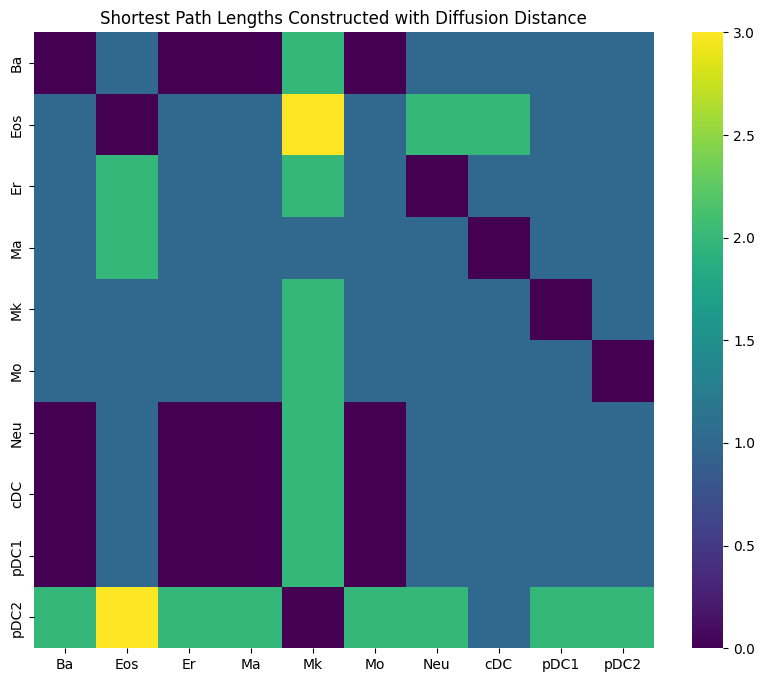

In [202]:
path_lengths_df = pd.DataFrame(shortest_path_lengths)

# Define the labels for the axes

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(path_lengths_df, cmap="viridis", xticklabels=labels, yticklabels=labels)

# Add the title
plt.title("Shortest Path Lengths Constructed with Diffusion Distance")

# Save the figure with a DPI of 300
plt.savefig('/gpfs/slayman/pi/gerstein/db2423/PROJECT/GNN/shortest_path_lengths_heatmap_diffusion.png', dpi=300)

# Display the plot
plt.show()

## Helper function

In [33]:
def extract_rows(csv_reader, csv_data_clone_cells):
    """
    Extract relevant row values from a csv.DictReader() object.

    Obs:
        In some datasets there may be a column, 'ident_name'
        which stores the names of the cell states.
        That column is used for parts that should output something
        about the cell states (e.g. metric values in the csv).
        However, in all datasets used for the analyses in the paper,
        there wasn't such column, so the column 'ident' itself is used
        as the column name.
    """
    row_tmp = {}
    for i, row in enumerate(csv_reader):
        # Store the register in a new dedicated list.
        # Discard all registers that had an empty value
        # for any of the fields
        # Also, for some reason, if cloneID is converted into a string
        # rather than a integer, then other, unrelated
        # floating computations become a little bit unstable
        # (e.g. the metric values begin to differ in
        # their latter decimals when computed with
        # the exact same parameters)
        row_tmp["cloneID"] = int(row["cloneID"])
        if(row_tmp["cloneID"] == ""):
            print("Register number {}.".format(i))
            print("cloneID is empty."
                    .format(row["cloneID"])
                    )
            continue

        row_tmp["ident_name"] = str(row["ident"])
        if(row_tmp["ident_name"] == ""):
            print("Register number {}.".format(i))
            print("ident_name is empty.\n"
                    .format(row["ident"])
                    )
            continue

        row_tmp["ident"] = str(row["ident"])
        if(row_tmp["ident"] == ""):
            print("Register number {}.".format(i))
            print("ident is empty.\n"
                .format(row["ident"])
                )
            continue

        csv_data_clone_cells.append(row_tmp.copy())
    return csv_data_clone_cells

def parse_csv_data(csv_data_url, csv_data_file):
    """
    Return the relevant parsed data from a selected source.

    The relevant data are constituted by:
        1) Data of cells that belong to a clone,
        without including the name of the cluster.
        2) The names of each cluster.
    """
    csv_data_clone_cells = []
    # Before calling this function, if the selected source was
    # a csv file, then csv_data_url was set to None. Otherwise,
    # the url source has priority.
    if(csv_data_url is not None):
        response = requests.get(csv_data_url)
        with closing(requests.get(csv_data_url, stream=True)) as req:
            csv_reader = csv.DictReader(codecs.iterdecode(
                                                req.iter_lines(), 'utf-8'))
            csv_data_clone_cells = extract_rows(csv_reader
                                                    , csv_data_clone_cells)
    else:
        with open(csv_data_file, newline='') as csvfile:   ###
            csv_reader = csv.DictReader(csvfile)
            csv_data_clone_cells = extract_rows(csv_reader
                                                    , csv_data_clone_cells)
            csvfile.close()
    return csv_data_clone_cells

def compute_clones_distribution(csv_data_clone_cells):
    """Return a counter of cells per clone."""
    clones = collections.Counter()
    for row in csv_data_clone_cells:
        cloneID = row["cloneID"]
        clones[cloneID] += 1
    return clones

def compute_clusters_distribution(csv_data_clone_cells):
    """Return a counter of cells per cluster, and their names."""
    clusters = collections.Counter()
    clusters_names = {}
    for row in csv_data_clone_cells:
        clusterID = row["ident"]
        cluster_name = row["ident_name"]
        clusters[clusterID] += 1
        clusters_names[clusterID] = cluster_name
    return clusters, clusters_names

def generate_cluster_pairs(clusters_list):
    """
    Return a dictionary-valued dictionary, indexed by the cluster pairs.

    The indices are 2-tuples, whose elements are the clusterIDs.
    Despite this, each pair is conceptually considered to be
    an unordered pair, and hereby appearing only once.
    This dictionary will later store all relevant data
    of each pair of clusters:
        - The metric values for the clusters
        (according to the definition given
        in the Methods section of the paper),
        resulting from the data in the dataset.
        - The parameters of the distribution of metric values
        resulting from doing the shuffling of cell cluster assignments.
        - The z-score of the first with respect to the second.
    """
    cluster_pairs = {}
    for cluster_pair in itertools.combinations_with_replacement(
                                                    clusters_list, 2):
        cluster_pairs[cluster_pair] = {}
    return cluster_pairs

def compute_num_cells_per_clones_per_cluster(csv_data_clone_cells):
    """
    Return a multi-level counter with different cell counts per level.

    Each count is stored in a field named "total".
    What is counted on each level:
        1) Total number of cells.
        2) Total number of cells per cluster.
        3) Total number of cells per clone per cluster.
    """
    num_cells = collections.Counter()
    num_cells["total"] = 0
    for cell in csv_data_clone_cells:
        cluster = cell["ident"]
        clone = cell["cloneID"]
        num_cells["total"] += 1
        if(cluster not in num_cells):
            num_cells[cluster] = collections.Counter()
            num_cells[cluster]["total"] = 0
        num_cells[cluster]["total"] += 1
        if(clone not in num_cells[cluster]):
            num_cells[cluster][clone] = collections.Counter()
            num_cells[cluster][clone]["total"] = 0
        num_cells[cluster][clone]["total"] += 1
    return num_cells

def compute_total_num_cells_of_shared_clone_and_cluster_pair(clone
    , cluster_pair, num_cells):
    """
    Return the number of cells in a cluster pair and its shared clone.

    For a clone and a cluster pair,
    if the clone was "shared" by the cluster pair (according to the
    corresponding definition in the Methods section of the paper),
    count the cells that belonged to the clone
    and also were assigned to one of the two clusters.
    If the clone was not shared between the clusters, return 0.
    """
    total_num_cells_of_shared_clone_and_cluster_pair = 0
    # The number of cells of the shared clone of each cluster is added
    for cluster in cluster_pair:
        # If no cells of a clone were assigned to any of the clusters
        if(clone not in num_cells[cluster]
                    or num_cells[cluster][clone]["total"] < 1):
            # Then that clone isn't "shared" by the pair
            return 0
        # If the cluster pair is composed by the same cluster
        if(cluster_pair[0] == cluster_pair[1]):
            # Then the total number of cells of the shared clone
            # is just that of that cluster
            total_num_cells_of_shared_clone_and_cluster_pair = (
                                        num_cells[cluster][clone]["total"])
            break
        else:
            total_num_cells_of_shared_clone_and_cluster_pair += (
                                        num_cells[cluster][clone]["total"])
    # If there were less than 2 cells of a clone
    # that were assigned to any of the clusters, then
    # that clone isn't "shared" between them
    if(total_num_cells_of_shared_clone_and_cluster_pair < 2):
        return 0
    else:
        return total_num_cells_of_shared_clone_and_cluster_pair

def compute_metric_value_single_pair(num_cells, cluster_pair, clones):
    """
    Return the metric value of a cluster pair.

    (According to the definition
    given in the Methods section of the paper).
    """
    metric_value = 0
    # For each clone that had cells assigned to any of the states
    for clone in set(itertools.chain(num_cells[cluster_pair[0]].keys()
                                    , num_cells[cluster_pair[1]].keys())
                    ):
        # Note that in the previous operation, as num_cells stores
        # the total value in a separated field, in the same level that
        # the clones, the "total" field is also included
        if(clone == "total"):
            # So skip it
            continue
        # Only the cells that belonged to shared clones are added
        total_num_cells_of_shared_clone_and_cluster_pair = (
                compute_total_num_cells_of_shared_clone_and_cluster_pair(
                                            clone, cluster_pair, num_cells))
        # Compute and store the relative value with respect to the
        # total number of cells in the (shared) clone
        metric_value += (total_num_cells_of_shared_clone_and_cluster_pair
                                                            / clones[clone])
    return metric_value

def compute_metric_values_all_pairs(num_cells, cluster_pairs, clones):
    """
    Return the metric value of each cluster pair.

    It is stored in a dictionary field, indexed by the cluster pair.
    """
    for cluster_pair in cluster_pairs:
        cluster_pairs[cluster_pair]["metric_value"] = (
                    compute_metric_value_single_pair(
                                num_cells, cluster_pair, clones))
    return cluster_pairs

def random_sample_with_frequency(freq_table):
    """
    Return a random sample of a given distribution.

    The elements are determined by freq_table, which is expected to be
    a collections.Counter() object
    (and hereby store counts of elements).
    """
    elements = list(freq_table.elements())
    total_elements = len(elements)
    sample = tuple(random.sample(elements, k=total_elements))
    return list(sample)

def print_matrix_onto_csv(array_2d, clusters_names_array_order
    , csv_matrix_output_file):
    """
    Write a matrix of values for each cluster pair into a csv file.
    """
    with open(csv_matrix_output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write the column indexes in the first row
        writer.writerow(["ident_name"] + clusters_names_array_order)
        # Write each row, beginning by its corresponding index
        for cluster_name, row in zip(
                                clusters_names_array_order, array_2d):
            writer.writerow([cluster_name] + list(row))
        csvfile.close()

def write_matrix(title, fieldname, cluster_pairs, clusters, clusters_names
    , csv_matrix_output_file):
    """
    Write a matrix of values of each cluster pair into a csv file.

    Also, return the matrix in a 2D list form,
    and a list with the cluster names.
    Parameters:
        title: string that contains the title of the matrix to be
        outputed. It's just for outputing a message in the console.
        fieldname: in the dictionary cluster_pairs, it's the
        name of the field whose values are desired to be written.
        cluster_pairs: dictionary indexed by the cluster pairs,
        among whose attributes should be fieldname.
        clusters: a collections.Counter() object with the
        frequency distribution of the clusters.
        clusters_names: a list that stores, for each clusterID,
        its corresponding name.
        csv_matrix_output_file: string with the file path where
        the matrix is desired to be written.
    """
    # First, transform the data
    # to a structure accepted by the used libraries.

    # Create a 2-D array form of the values in cluster_pairs,
    # and a list that stores the clusters in the order
    # in which they occur in that array (along the columns or rows)
    matrix, clusters_list_array_order = (
                dict_to_array(cluster_pairs, len(clusters)
                                            , fieldname)
            )
    print(title + ":")
    print_2D_float_list(matrix)
    # Create a list that stores the cluster names, in the order
    # in which they occur in the 2D array (along the columns or rows)
    clusters_names_array_order = [
            clusters_names[cluster] for cluster in clusters_list_array_order]
    print_matrix_onto_csv(matrix, clusters_names_array_order
                            , csv_matrix_output_file)

    return matrix, clusters_names_array_order

def compute_distribution_parameters(number_list):
    """Return the mean and standard deviation of a number list."""
    return (float(statistics.mean(number_list))
            , float(statistics.stdev(number_list)))

def compute_distributions(cluster_pairs, num_shufflings
    , csv_data_clone_cells, clusters):
    """
    Return distribution parameters for each cluster pair.

    Do the cell cluster assignment shufflings,
    simulate the resulting assignments, and for each pair of clusters
    compute and store in a list
    the metric values resulting from each shuffling.
    Then compute and store the means and standard deviations
    of the resulting distributions.
    """
    # List that will store the simulated data in each shuffling
    csv_data_clone_cells_local_shuffle = copy.deepcopy(csv_data_clone_cells)
    # Dictionary that will store in lists the metric values
    # obtained over the shufflings for each cluster pair
    cluster_pairs_shufflings = generate_cluster_pairs(clusters.keys())
    for cluster_pair in cluster_pairs_shufflings:
        cluster_pairs_shufflings[cluster_pair]["metric_value"] = []
    # Dictionary, local to each shuffling,
    # that will store the metric values for each cluster pair
    cluster_pairs_local_shuffle = generate_cluster_pairs(clusters.keys())

    for shuffling in range(0, num_shufflings):
        # Perform the random shuffling of cluster assigments
        clusters_assignment = random_sample_with_frequency(clusters)
        # Simulate cell cluster assignments
        for i, csv_data_clone_cell_local in enumerate(
                                        csv_data_clone_cells_local_shuffle):
            csv_data_clone_cell_local["ident"] = clusters_assignment[i]
        # Compute the metric value for each cluster pair
        # observed in the current sample.
        clones = compute_clones_distribution(
                                        csv_data_clone_cells_local_shuffle)
        num_cells = compute_num_cells_per_clones_per_cluster(
                                        csv_data_clone_cells_local_shuffle)
        cluster_pairs_local_shuffle = compute_metric_values_all_pairs(
                            num_cells, cluster_pairs_local_shuffle, clones)
        # Append the current shuffling's results to the lists
        for cluster_pair in cluster_pairs_local_shuffle:
            cluster_pairs_shufflings[
                    cluster_pair]["metric_value"].append(
                                        cluster_pairs_local_shuffle[
                                                cluster_pair]["metric_value"])

    # Compute, for each cluster pair, the parameters
    # of the metric values distributions resulting from the simulations
    for cluster_pair in cluster_pairs_shufflings:
        (cluster_pairs[cluster_pair]["avg_metric_value"]
                , cluster_pairs[cluster_pair]["stdv_metric_value"]) \
                = compute_distribution_parameters(
                                        cluster_pairs_shufflings[
                                                cluster_pair]["metric_value"])
    return cluster_pairs

def compute_z_scores(cluster_pairs):
    """
    Return the z-scores for each pair of clusters.

    The z-scores are of the metric values of the clusters
    (according to the definition
    given in the Methods section of the paper),
    resulting from the data in the dataset,
    with respect to their corresponding distributions of metric values
    resulting from doing the cell cluster assignments shufflings.
    Obs:
        There is a special case when a pair of clusters
        obtains the same metric value in all shufflings
        (and hereby its distribution's stdev=0
        and the z-score is not defined).
        A "N/A" value is assigned to those clusters in this case
        instead of a z-score value.
        In practice, however, this case is unlikely, and even more
        when N is large.
    """
    cluster_pairs_infinite_z_score = []
    for cluster_pair in cluster_pairs:
        deviation = (float(cluster_pairs[cluster_pair]["metric_value"])
                        -cluster_pairs[cluster_pair]["avg_metric_value"])
        if(cluster_pairs[cluster_pair]["stdv_metric_value"] == 0):
            print("Pair {} had a stdev = 0, with a deviation = {}"
                                            .format(cluster_pair, deviation))
            print(cluster_pairs[cluster_pair])
            cluster_pairs_infinite_z_score.append(cluster_pair)
        else:
            cluster_pairs[
                    cluster_pair]["metric_value_z_score"] = (
                                    deviation
                                    / cluster_pairs[
                                            cluster_pair]["stdv_metric_value"]
                            )
    for cluster_pair in cluster_pairs_infinite_z_score:
        cluster_pairs[cluster_pair]["metric_value_z_score"] = "N/A"
    return cluster_pairs

def print_2D_float_list(l):
    """Print a 2D list of floats in a row-wise format."""
    for row in l:
        for col in row:
            print("{:8.1f}".format(col), end=" ")
        print("")

def dict_to_array(cluster_pairs, num_clusters, key_name):
    """
    Return a 2D list with a value for each cluster pair, and their IDs.

    The value for each cluster pair is obtained from the key
    named key_name.
    The 2D list to be returned is conceptually considered to be
    a 2D array, with the rows and columns corresponding to
    the first and second clusters of the cluster pairs,
    and viceversa (to fill the whole matrix).
    The cell value will be the corresponding item stored in the field
    key_name.
    The list of row/column IDs is in insertion order, which is the same
    that the order in which they appear in a cluster pair
    when the latter are iterated over.
    Obs:
        The latter means that the order of the cluster IDs (idents)
        is not maintained, but it depends on
        when it appears within a cluster pair,
        and when that cluster pair appears
        in the iteration of cluster pairs.
    """
    # Ordered Dictionary that will store the indexes in the array
    # corresponding to each of the clusters
    array_indexes = collections.OrderedDict()
    max_array_index = -1
    # Initialize the array to a (num_clusters x num_clusters) shape
    array_2D = np.array([
                                [0.0 for i in range(num_clusters)]
                            for j in range(num_clusters)])
    for cluster_pair in cluster_pairs:
        for cluster in cluster_pair:
            if(cluster not in array_indexes):
                max_array_index += 1
                print("array_indexes[{}] = {}"
                        .format(cluster, max_array_index))
                # As array_indexes is an Ordered Dict, the order in
                # which the indexes were inserted (and the dict keys
                # created) will correspond to the indexes themselves
                array_indexes[cluster] = max_array_index
        # Fill the matrix with the corresponding value
        array_2D[
                array_indexes[cluster_pair[0]]][
                array_indexes[cluster_pair[1]]] = cluster_pairs[cluster_pair][
                                                                    key_name]
        # In both orders (to fill the whole matrix)
        array_2D[
                array_indexes[cluster_pair[1]]][
                array_indexes[cluster_pair[0]]] = cluster_pairs[cluster_pair][
                                                                    key_name]
    # The keys in insertion order of array_indexes are the
    # clusterIDs in the order that they will appear in the new 2D array
    keys_in_insertion_order = [key for key in array_indexes]
    return array_2D, keys_in_insertion_order

def plot_clustermap(title, array_2D, labels_array_order, vmin, vmax, output_dir, add_annot):
    """
    Plot clustermap of the values in array_2D.

    An optional step of hiding the upper triangular matrix
    can be taken.
    """
    # print(title)
    # print_2D_float_list(array_2D)
    mask = np.zeros_like(array_2D)
    # Set the next assigment to False for plotting
    # the whole matrix, and to True for only the lower triangular matrix
    # with the diagonal
    mask[np.triu_indices_from(mask)] = False
    mask[np.diag_indices_from(mask)] = False
    with sns.axes_style("white"):
        ax = sns.clustermap(array_2D
                    , xticklabels = labels_array_order
                    , yticklabels = labels_array_order
                    , mask=mask, vmin=vmin, vmax=vmax
                    , annot=add_annot
                    # , square=True
                    , cmap="Blues")
        plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    # save heatmap
    plt.savefig(output_dir, dpi=300, bbox_inches="tight", format="png")
    plt.show()

def output_lineage_coupling_computations(
    cluster_pairs, clusters, clusters_names
    , csv_lineage_coupling_scores_matrix_output_file, vmin, vmax, output_dir, add_annot=False):
    """
    Output computations related to clusters' lineage couplings.

    The computations of the lineage coupling scores,
    outputed in the form of:
        - a matrix onto a csv
        - and a clustermap in a plot
    """
    # First, transform data to a structure accepted by seaborn methods.

    # The 2D array form of the z-scores,
    # and a list that stores the order of the clusters
    # in which they occur in that array (along the columns or rows)
    z_scores_array, clusters_list_array_order = (
                dict_to_array(cluster_pairs, len(clusters)
                        , "metric_value_z_score")
            )
    print("Lineage Coupling Matrix:")
    print_2D_float_list(z_scores_array)
    clusters_names_array_order = [
            clusters_names[cluster] for cluster in clusters_list_array_order]
    print_matrix_onto_csv(z_scores_array, clusters_names_array_order
                , csv_lineage_coupling_scores_matrix_output_file)
    plot_clustermap("Lineage Coupling Scores", z_scores_array
                                    , clusters_names_array_order, vmin, vmax, output_dir, add_annot)

In [34]:
# construct euclidean distance
n=10
def compute_distances(X):
  # n is the number of points 
 
 return squareform(pdist(X, 'euclidean')) 

# compute affinity matrix
def compute_affinity_matrix(D, kernel_type, sigma=None, k=None):
  W = np.zeros((n,n), dtype = 'float64')  
  if kernel_type == 'gaussian':  
        sigma > 0
        W= np.exp(-D**2/sigma**2)
  else:
        kernel_type == 'adaptive'
        sigma = np.zeros((n,1), dtype = 'float64')  
        for m in range(0,n):
          # sort distance in ascending order of each row in D (distance matrix)
           sortD=sorted(D[m,:],reverse=False)
          # construct sigma where sigma of i is the distance from i to its k nearest neighbor
           sigma[m]=sortD[k]
        for i in range(0,n): 
          for j in range (0,n):  
          # compute adapative gaussian kernel
            W[i][j]=0.5 *(np.exp(-D[i][j]**2/sigma[i]**2)+np.exp(-D[i][j]**2/sigma[j]**2))
  
  return W

def diff_map_info(W):
# compute D (diagonal matrix of row sums)
 Dia=np.diag(np.sum(W, axis=1))
# create symmetrix matrix 
# diffusion matrix
 Ms=la.inv(Dia)**(1/2)@ W @la.inv(Dia)**(1/2)
# compute eigenpairs of Ms and order eigenvector in descending order
 eigval, eigvec = la.eigh(Ms)
 idx=eigval.argsort()[::-1]
 eigval=eigval[idx]
 eigvec=eigvec[:,idx]
# compute eigenvectors and eigenvalues of M
 diff_vec1=la.inv(Dia**(1/2))@ eigvec
 diff_vec=(diff_vec1/np.linalg.norm(diff_vec1,axis=0))
 diff_eig=eigval[1:]
 diff_vec=diff_vec[:,1:]
 return diff_vec,diff_eig

def get_diff_map(diff_vec,diff_eig,t):
  # eigenvalue in diffusion map
  eigvaluet=diff_eig**t
  diff_map=diff_vec @ np.diag(eigvaluet)
  return diff_map
